In [221]:
import pandas as pd
import numpy as np
import sqlite3
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pyreadstat
import matplotlib.cm as cm
import sompy
from sompy.visualization.mapview import View2D
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView
from math import ceil
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from datetime import datetime
from sklearn.cluster import AgglomerativeClustering
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from pandas_profiling import ProfileReport
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift, DBSCAN, estimate_bandwidth
sns.set()

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

Loaded backend module://ipykernel.pylab.backend_inline version unknown.


# Reading the Data

In [5]:
df, meta = pyreadstat.read_sas7bdat('a2z_insurance.sas7bdat')

In [6]:
df.head()

CustID  FirstPolYear  BirthYear          EducDeg  MonthSal  GeoLivArea  \
0     1.0        1985.0     1982.0  2 - High School    2177.0         1.0   
1     2.0        1981.0     1995.0  2 - High School     677.0         4.0   
2     3.0        1991.0     1970.0        1 - Basic    2277.0         3.0   
3     4.0        1990.0     1981.0      3 - BSc/MSc    1099.0         4.0   
4     5.0        1986.0     1973.0      3 - BSc/MSc    1763.0         4.0   

   Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
0       1.0      380.97        0.39     375.85          79.45      146.36   
1       1.0     -131.13        1.12      77.46         416.20      116.69   
2       0.0      504.67        0.28     206.15         224.50      124.58   
3       1.0      -16.99        0.99     182.48          43.35      311.17   
4       1.0       35.23        0.90     338.62          47.80      182.59   

   PremLife  PremWork  
0     47.01     16.89  
1    194.48    106.13  
2     86.35     99.02  
3     35.34     28.34  
4     18.78     41.45

# Make a copy of  original dataset

In [7]:
df_original = df.copy()

In [8]:
# Change The Column Namr
df.rename(columns={'CustID': 'ID', 'FirstPolYear': 'First Policy', 'BirthYear':'Birthday', 'EducDeg':'Education','MonthSal':'Salary','GeoLivArea':'Area','CustMonVal':'CMV', 'ClaimsRate':'Claims', 'PremMotor': 'Motor', 'PremHousehold':'Household','PremHealth': 'Health', 'PremLife':'Life', 'PremWork':'Work Compensation'  }, inplace=True)
df

ID  First Policy  Birthday        Education  Salary  Area  \
0          1.0        1985.0    1982.0  2 - High School  2177.0   1.0   
1          2.0        1981.0    1995.0  2 - High School   677.0   4.0   
2          3.0        1991.0    1970.0        1 - Basic  2277.0   3.0   
3          4.0        1990.0    1981.0      3 - BSc/MSc  1099.0   4.0   
4          5.0        1986.0    1973.0      3 - BSc/MSc  1763.0   4.0   
...        ...           ...       ...              ...     ...   ...   
10291  10292.0        1984.0    1949.0          4 - PhD  3188.0   2.0   
10292  10293.0        1977.0    1952.0        1 - Basic  2431.0   3.0   
10293  10294.0        1994.0    1976.0      3 - BSc/MSc  2918.0   1.0   
10294  10295.0        1981.0    1977.0        1 - Basic  1971.0   2.0   
10295  10296.0        1990.0    1981.0          4 - PhD  2815.0   1.0   

       Children      CMV  Claims   Motor  Household  Health    Life  \
0           1.0   380.97    0.39  375.85      79.45  146.36   47.01   
1           1.0  -131.13    1.12   77.46     416.20  116.69  194.48   
2           0.0   504.67    0.28  206.15     224.50  124.58   86.35   
3           1.0   -16.99    0.99  182.48      43.35  311.17   35.34   
4           1.0    35.23    0.90  338.62      47.80  182.59   18.78   
...         ...      ...     ...     ...        ...     ...     ...   
10291       0.0    -0.11    0.96  393.74      49.45  173.81    9.78   
10292       0.0  1405.60    0.00  133.58    1035.75  143.25   12.89   
10293       1.0   524.10    0.21  403.63     132.80  142.25   12.67   
10294       1.0   250.05    0.65  188.59     211.15  198.37   63.90   
10295       1.0   463.75    0.27  414.08      94.45  141.25    6.89   

       Work Compensation  
0                  16.89  
1                 106.13  
2                  99.02  
3                  28.34  
4                  41.45  
...                  ...  
10291              14.78  
10292             105.13  
10293               4.89  
10294             112.91  
10295              12.89  

[10296 rows x 14 columns]

In [9]:
# replace "" by nans
df.replace("", np.nan, inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10296 entries, 0 to 10295
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 10296 non-null  float64
 1   First Policy       10266 non-null  float64
 2   Birthday           10279 non-null  float64
 3   Education          10279 non-null  object 
 4   Salary             10260 non-null  float64
 5   Area               10295 non-null  float64
 6   Children           10275 non-null  float64
 7   CMV                10296 non-null  float64
 8   Claims             10296 non-null  float64
 9   Motor              10262 non-null  float64
 10  Household          10296 non-null  float64
 11  Health             10253 non-null  float64
 12  Life               10192 non-null  float64
 13  Work Compensation  10210 non-null  float64
dtypes: float64(13), object(1)
memory usage: 1.1+ MB


In [11]:
df.dtypes

ID                   float64
First Policy         float64
Birthday             float64
Education             object
Salary               float64
Area                 float64
Children             float64
CMV                  float64
Claims               float64
Motor                float64
Household            float64
Health               float64
Life                 float64
Work Compensation    float64
dtype: object

In [12]:
# Check for duplicated observations
df.duplicated().sum()

0

In [13]:
# Get the basic descriptive statistics on for the numeric variables
df.describe().T # .T for cleaner visualization

count         mean          std        min      25%  \
ID                 10296.0  5148.500000  2972.343520       1.00  2574.75   
First Policy       10266.0  1991.062634   511.267913    1974.00  1980.00   
Birthday           10279.0  1968.007783    19.709476    1028.00  1953.00   
Salary             10260.0  2506.667057  1157.449634     333.00  1706.00   
Area               10295.0     2.709859     1.266291       1.00     1.00   
Children           10275.0     0.706764     0.455268       0.00     0.00   
CMV                10296.0   177.892605  1945.811505 -165680.42    -9.44   
Claims             10296.0     0.742772     2.916964       0.00     0.39   
Motor              10262.0   300.470252   211.914997      -4.11   190.59   
Household          10296.0   210.431192   352.595984     -75.00    49.45   
Health             10253.0   171.580833   296.405976      -2.11   111.80   
Life               10192.0    41.855782    47.480632      -7.00     9.89   
Work Compensation  10210.0    41.277514    51.513572     -12.00    10.67   

                       50%        75%       max  
ID                 5148.50  7722.2500  10296.00  
First Policy       1986.00  1992.0000  53784.00  
Birthday           1968.00  1983.0000   2001.00  
Salary             2501.50  3290.2500  55215.00  
Area                  3.00     4.0000      4.00  
Children              1.00     1.0000      1.00  
CMV                 186.87   399.7775  11875.89  
Claims                0.72     0.9800    256.20  
Motor               298.61   408.3000  11604.42  
Household           132.80   290.0500  25048.80  
Health              162.81   219.8200  28272.00  
Life                 25.56    57.7900    398.30  
Work Compensation    25.67    56.7900   1988.70

In [14]:
df.describe(include="all").T

NumExpr defaulting to 4 threads.


count unique          top  freq      mean       std  \
ID                 10296    NaN          NaN   NaN    5148.5   2972.34   
First Policy       10266    NaN          NaN   NaN   1991.06   511.268   
Birthday           10279    NaN          NaN   NaN   1968.01   19.7095   
Education          10279      4  3 - BSc/MSc  4799       NaN       NaN   
Salary             10260    NaN          NaN   NaN   2506.67   1157.45   
Area               10295    NaN          NaN   NaN   2.70986   1.26629   
Children           10275    NaN          NaN   NaN  0.706764  0.455268   
CMV                10296    NaN          NaN   NaN   177.893   1945.81   
Claims             10296    NaN          NaN   NaN  0.742772   2.91696   
Motor              10262    NaN          NaN   NaN    300.47   211.915   
Household          10296    NaN          NaN   NaN   210.431   352.596   
Health             10253    NaN          NaN   NaN   171.581   296.406   
Life               10192    NaN          NaN   NaN   41.8558   47.4806   
Work Compensation  10210    NaN          NaN   NaN   41.2775   51.5136   

                      min      25%     50%      75%      max  
ID                      1  2574.75  5148.5  7722.25    10296  
First Policy         1974     1980    1986     1992    53784  
Birthday             1028     1953    1968     1983     2001  
Education             NaN      NaN     NaN      NaN      NaN  
Salary                333     1706  2501.5  3290.25    55215  
Area                    1        1       3        4        4  
Children                0        0       1        1        1  
CMV               -165680    -9.44  186.87  399.778  11875.9  
Claims                  0     0.39    0.72     0.98    256.2  
Motor               -4.11   190.59  298.61    408.3  11604.4  
Household             -75    49.45   132.8   290.05  25048.8  
Health              -2.11    111.8  162.81   219.82    28272  
Life                   -7     9.89   25.56    57.79    398.3  
Work Compensation     -12    10.67   25.67    56.79   1988.7

In [15]:
# descriptive statistics for the categorical variables
df.describe(include =['O']).T

count unique          top  freq
Education  10279      4  3 - BSc/MSc  4799

In [16]:
print("Checking Memory Use Each Columns");print()
df.memory_usage(deep=True)/1024**2

Checking Memory Use Each Columns



Index                0.000122
ID                   0.078552
First Policy         0.078552
Birthday             0.078552
Education            0.675411
Salary               0.078552
Area                 0.078552
Children             0.078552
CMV                  0.078552
Claims               0.078552
Motor                0.078552
Household            0.078552
Health               0.078552
Life                 0.078552
Work Compensation    0.078552
dtype: float64

# Define Metric and Categorical Features' Names

In [17]:
# Define metric and non-metric features. Why?
non_metric_features = ["Education"]
metric_features = df.columns.drop(non_metric_features).to_list()

# Fill missing values (Data imputation)

In [18]:
# Creating a copy to apply central tendency measures imputation
df_central = df.copy()

In [19]:
# count of missing values
df_central.isna().sum()

ID                     0
First Policy          30
Birthday              17
Education             17
Salary                36
Area                   1
Children              21
CMV                    0
Claims                 0
Motor                 34
Household              0
Health                43
Life                 104
Work Compensation     86
dtype: int64

In [20]:
df_central.median()

ID                   5148.50
First Policy         1986.00
Birthday             1968.00
Salary               2501.50
Area                    3.00
Children                1.00
CMV                   186.87
Claims                  0.72
Motor                 298.61
Household             132.80
Health                162.81
Life                   25.56
Work Compensation      25.67
dtype: float64

In [21]:
modes = df_central[non_metric_features].mode().loc[0]
modes

Education    3 - BSc/MSc
Name: 0, dtype: object

In [22]:
df_central.fillna(df_central.median(), inplace=True)
df_central.fillna(modes, inplace=True)
df_central.isna().sum()

ID                   0
First Policy         0
Birthday             0
Education            0
Salary               0
Area                 0
Children             0
CMV                  0
Claims               0
Motor                0
Household            0
Health               0
Life                 0
Work Compensation    0
dtype: int64

In [23]:
# Creating new df copy to explore neighbordhood imputation
df_neighbors = df.copy()

In [24]:
# Seeing rows with NaNs
nans_index = df_neighbors.isna().any(axis=1)
df_neighbors[nans_index]

ID  First Policy  Birthday        Education  Salary  Area  \
21        22.0        1977.0    1958.0  2 - High School     NaN   3.0   
68        69.0        1983.0    1977.0  2 - High School  1399.0   4.0   
138      139.0        1979.0    1976.0  2 - High School  2538.0   2.0   
143      144.0        1996.0    1990.0      3 - BSc/MSc     NaN   4.0   
184      185.0        1993.0    1984.0  2 - High School  2419.0   4.0   
...        ...           ...       ...              ...     ...   ...   
10010  10011.0           NaN    1947.0  2 - High School  3959.0   2.0   
10057  10058.0        1983.0    1980.0  2 - High School  1569.0   4.0   
10142  10143.0        1986.0    1985.0      3 - BSc/MSc  1652.0   3.0   
10284  10285.0        1980.0    1987.0      3 - BSc/MSc  1504.0   4.0   
10285  10286.0        1985.0    1948.0      3 - BSc/MSc  3878.0   4.0   

       Children     CMV  Claims   Motor  Household  Health    Life  \
21          1.0  111.37    0.80  407.52     111.70  100.13   24.67   
68          1.0  476.65    0.33  330.73     186.70  211.15     NaN   
138         1.0  149.59    0.69  194.26     305.60     NaN   37.34   
143         1.0  -42.45    1.02  146.36     353.95  220.04  121.80   
184         1.0  -62.23    1.07     NaN     253.95  230.60    5.89   
...         ...     ...     ...     ...        ...     ...     ...   
10010       NaN -128.24    1.14  177.81     153.35  311.28   67.79   
10057       1.0  222.60    0.55  235.60     211.15     NaN   32.34   
10142       1.0   55.67    0.88  257.05      94.45  308.39     NaN   
10284       1.0   -1.55    0.96  390.63      29.45  179.70   -6.00   
10285       1.0  -57.45    1.04  269.05     217.25  219.93   32.45   

       Work Compensation  
21                 30.34  
68                 15.78  
138                17.67  
143                42.01  
184                43.12  
...                  ...  
10010              35.45  
10057              68.79  
10142              13.78  
10284                NaN  
10285                NaN  

[309 rows x 14 columns]

In [25]:
# KNNImputer - only works for numerical varaibles
imputer = KNNImputer(n_neighbors=5, weights="uniform")
df_neighbors[metric_features] = imputer.fit_transform(df_neighbors[metric_features])

In [26]:
# See rows with NaNs imputed
df_neighbors.loc[nans_index, metric_features]

ID  First Policy  Birthday  Salary  Area  Children     CMV  \
21        22.0        1977.0    1958.0  3125.0   3.0       1.0  111.37   
68        69.0        1983.0    1977.0  1399.0   4.0       1.0  476.65   
138      139.0        1979.0    1976.0  2538.0   2.0       1.0  149.59   
143      144.0        1996.0    1990.0  2435.2   4.0       1.0  -42.45   
184      185.0        1993.0    1984.0  2419.0   4.0       1.0  -62.23   
...        ...           ...       ...     ...   ...       ...     ...   
10010  10011.0        1988.8    1947.0  3959.0   2.0       0.2 -128.24   
10057  10058.0        1983.0    1980.0  1569.0   4.0       1.0  222.60   
10142  10143.0        1986.0    1985.0  1652.0   3.0       1.0   55.67   
10284  10285.0        1980.0    1987.0  1504.0   4.0       1.0   -1.55   
10285  10286.0        1985.0    1948.0  3878.0   4.0       1.0  -57.45   

       Claims    Motor  Household   Health     Life  Work Compensation  
21       0.80  407.520     111.70  100.130   24.670             30.340  
68       0.33  330.730     186.70  211.150   22.516             15.780  
138      0.69  194.260     305.60  204.994   37.340             17.670  
143      1.02  146.360     353.95  220.040  121.800             42.010  
184      1.07  275.652     253.95  230.600    5.890             43.120  
...       ...      ...        ...      ...      ...                ...  
10010    1.14  177.810     153.35  311.280   67.790             35.450  
10057    0.55  235.600     211.15  235.466   32.340             68.790  
10142    0.88  257.050      94.45  308.390   24.916             13.780  
10284    0.96  390.630      29.45  179.700   -6.000             20.626  
10285    1.04  269.050     217.25  219.930   32.450             33.584  

[309 rows x 13 columns]

# Histograms of Metric Features

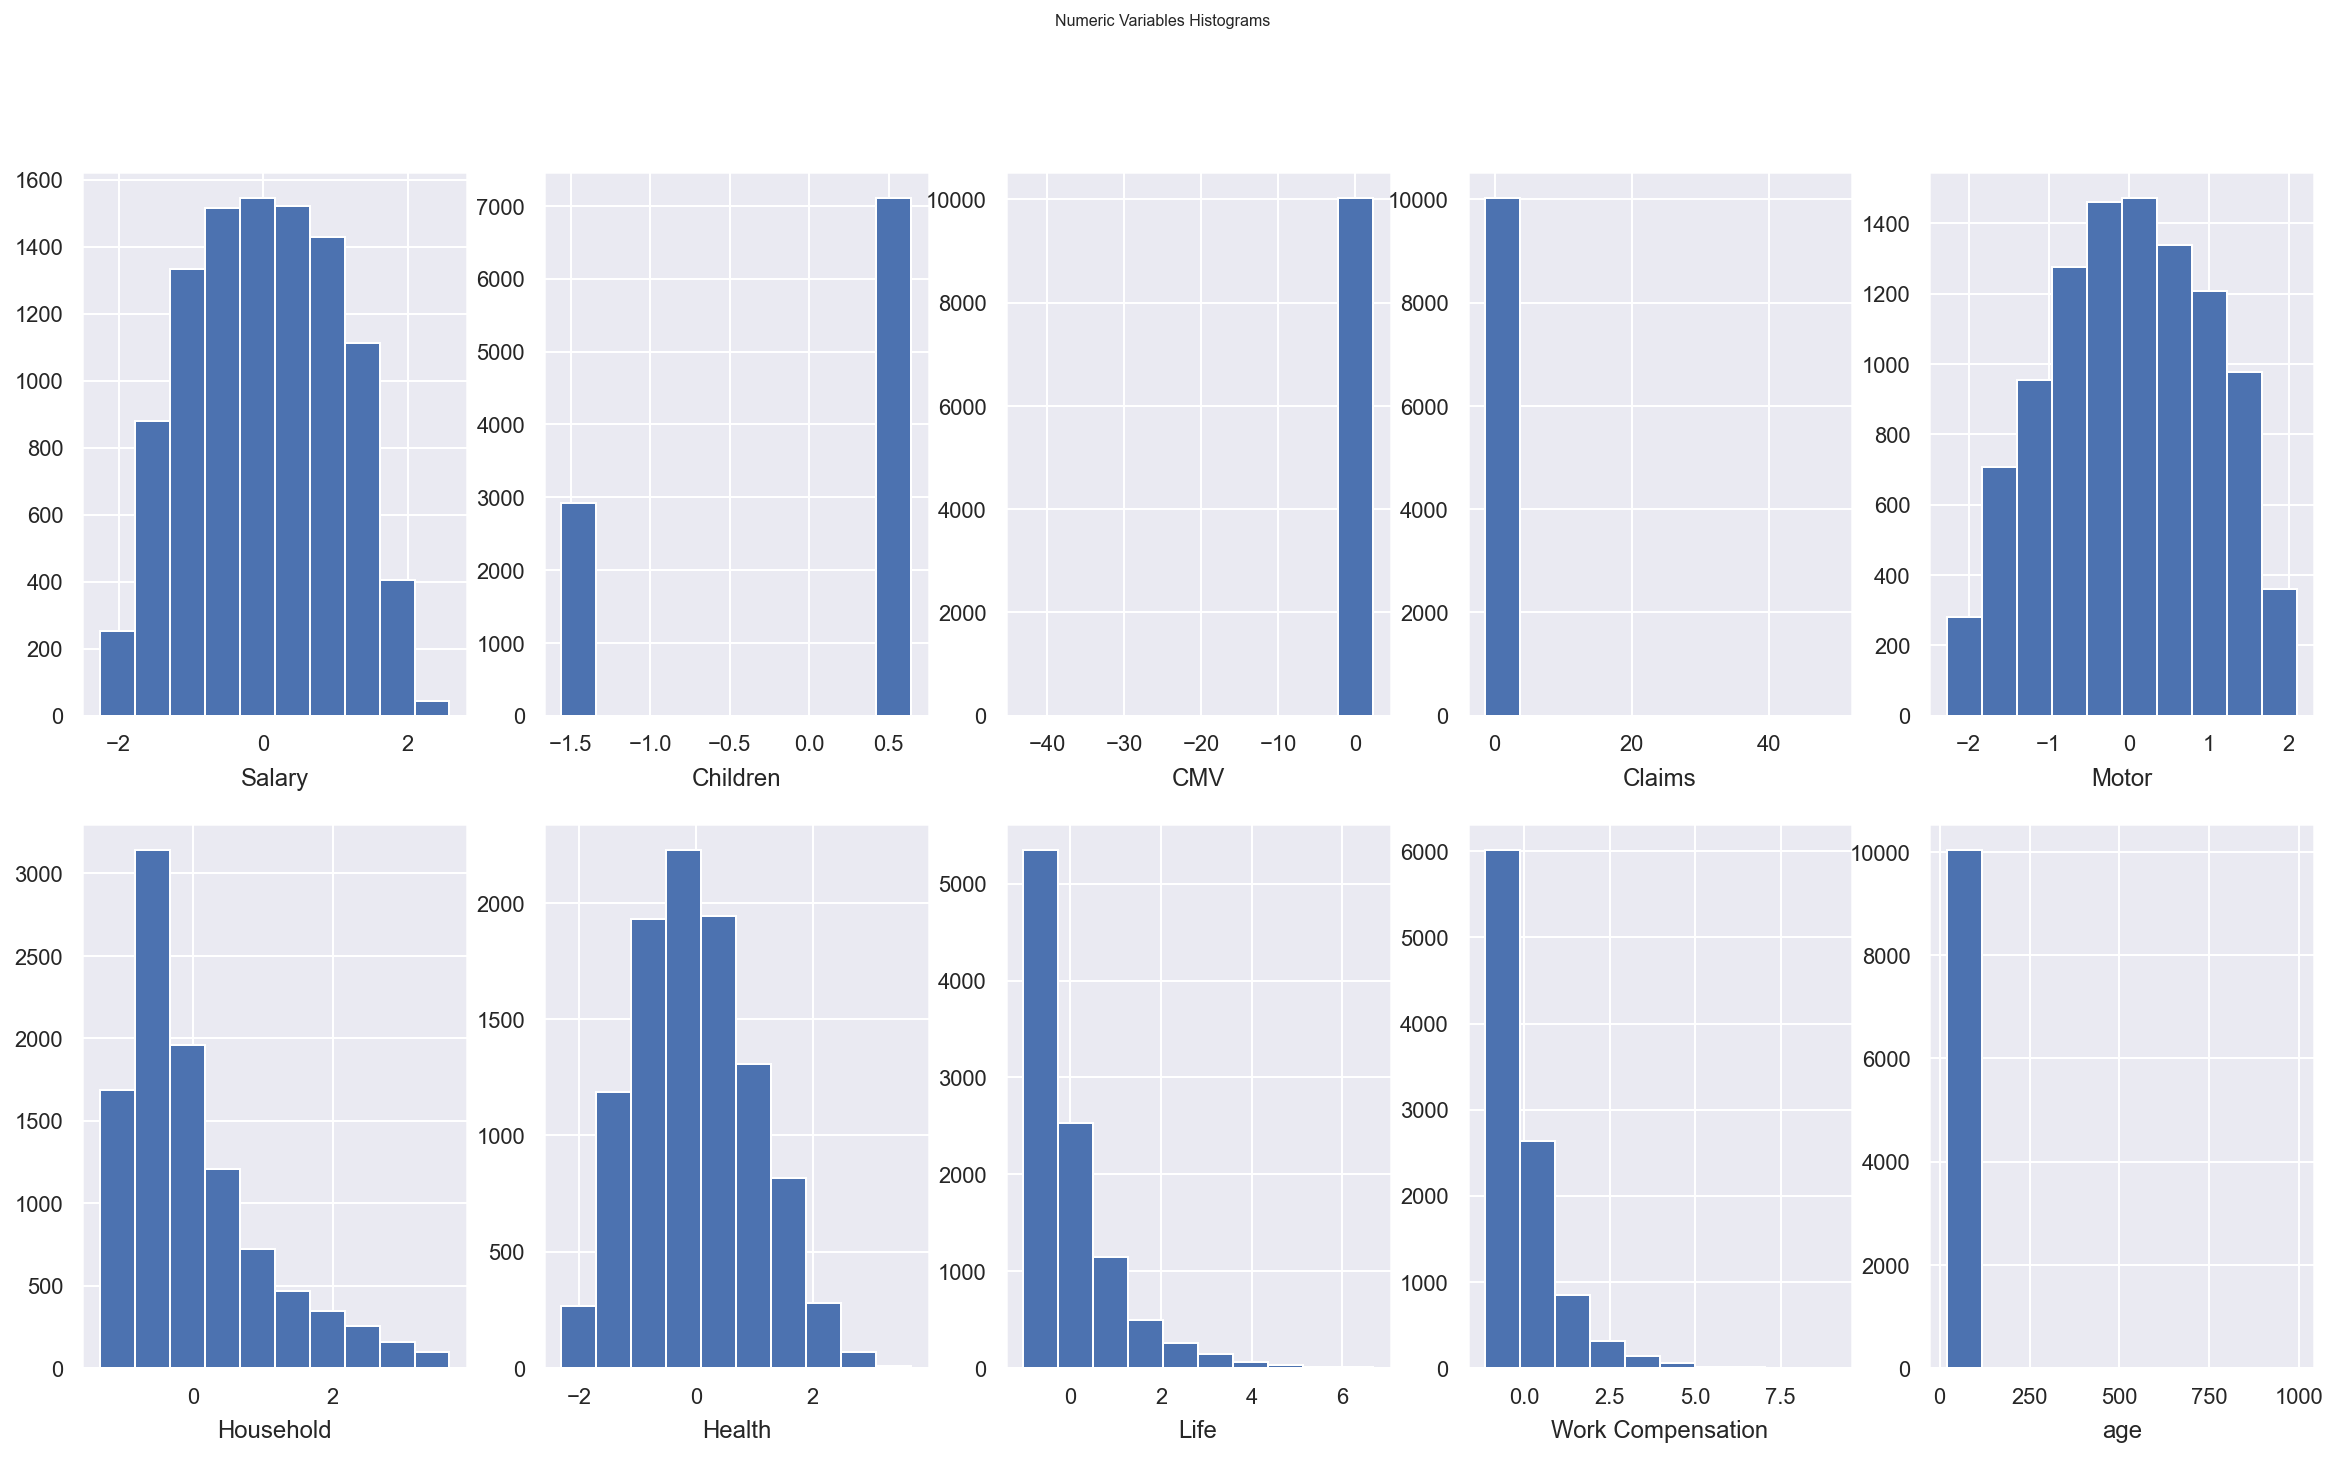

In [243]:
# All Numeric Variables' Histograms in one figure
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    ax.hist(df[feat], bins = 10)
    ax.set_title(feat, y = -0.15)    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables Histograms"

plt.suptitle(title)

plt.show()

# Boxplot of Metric Features

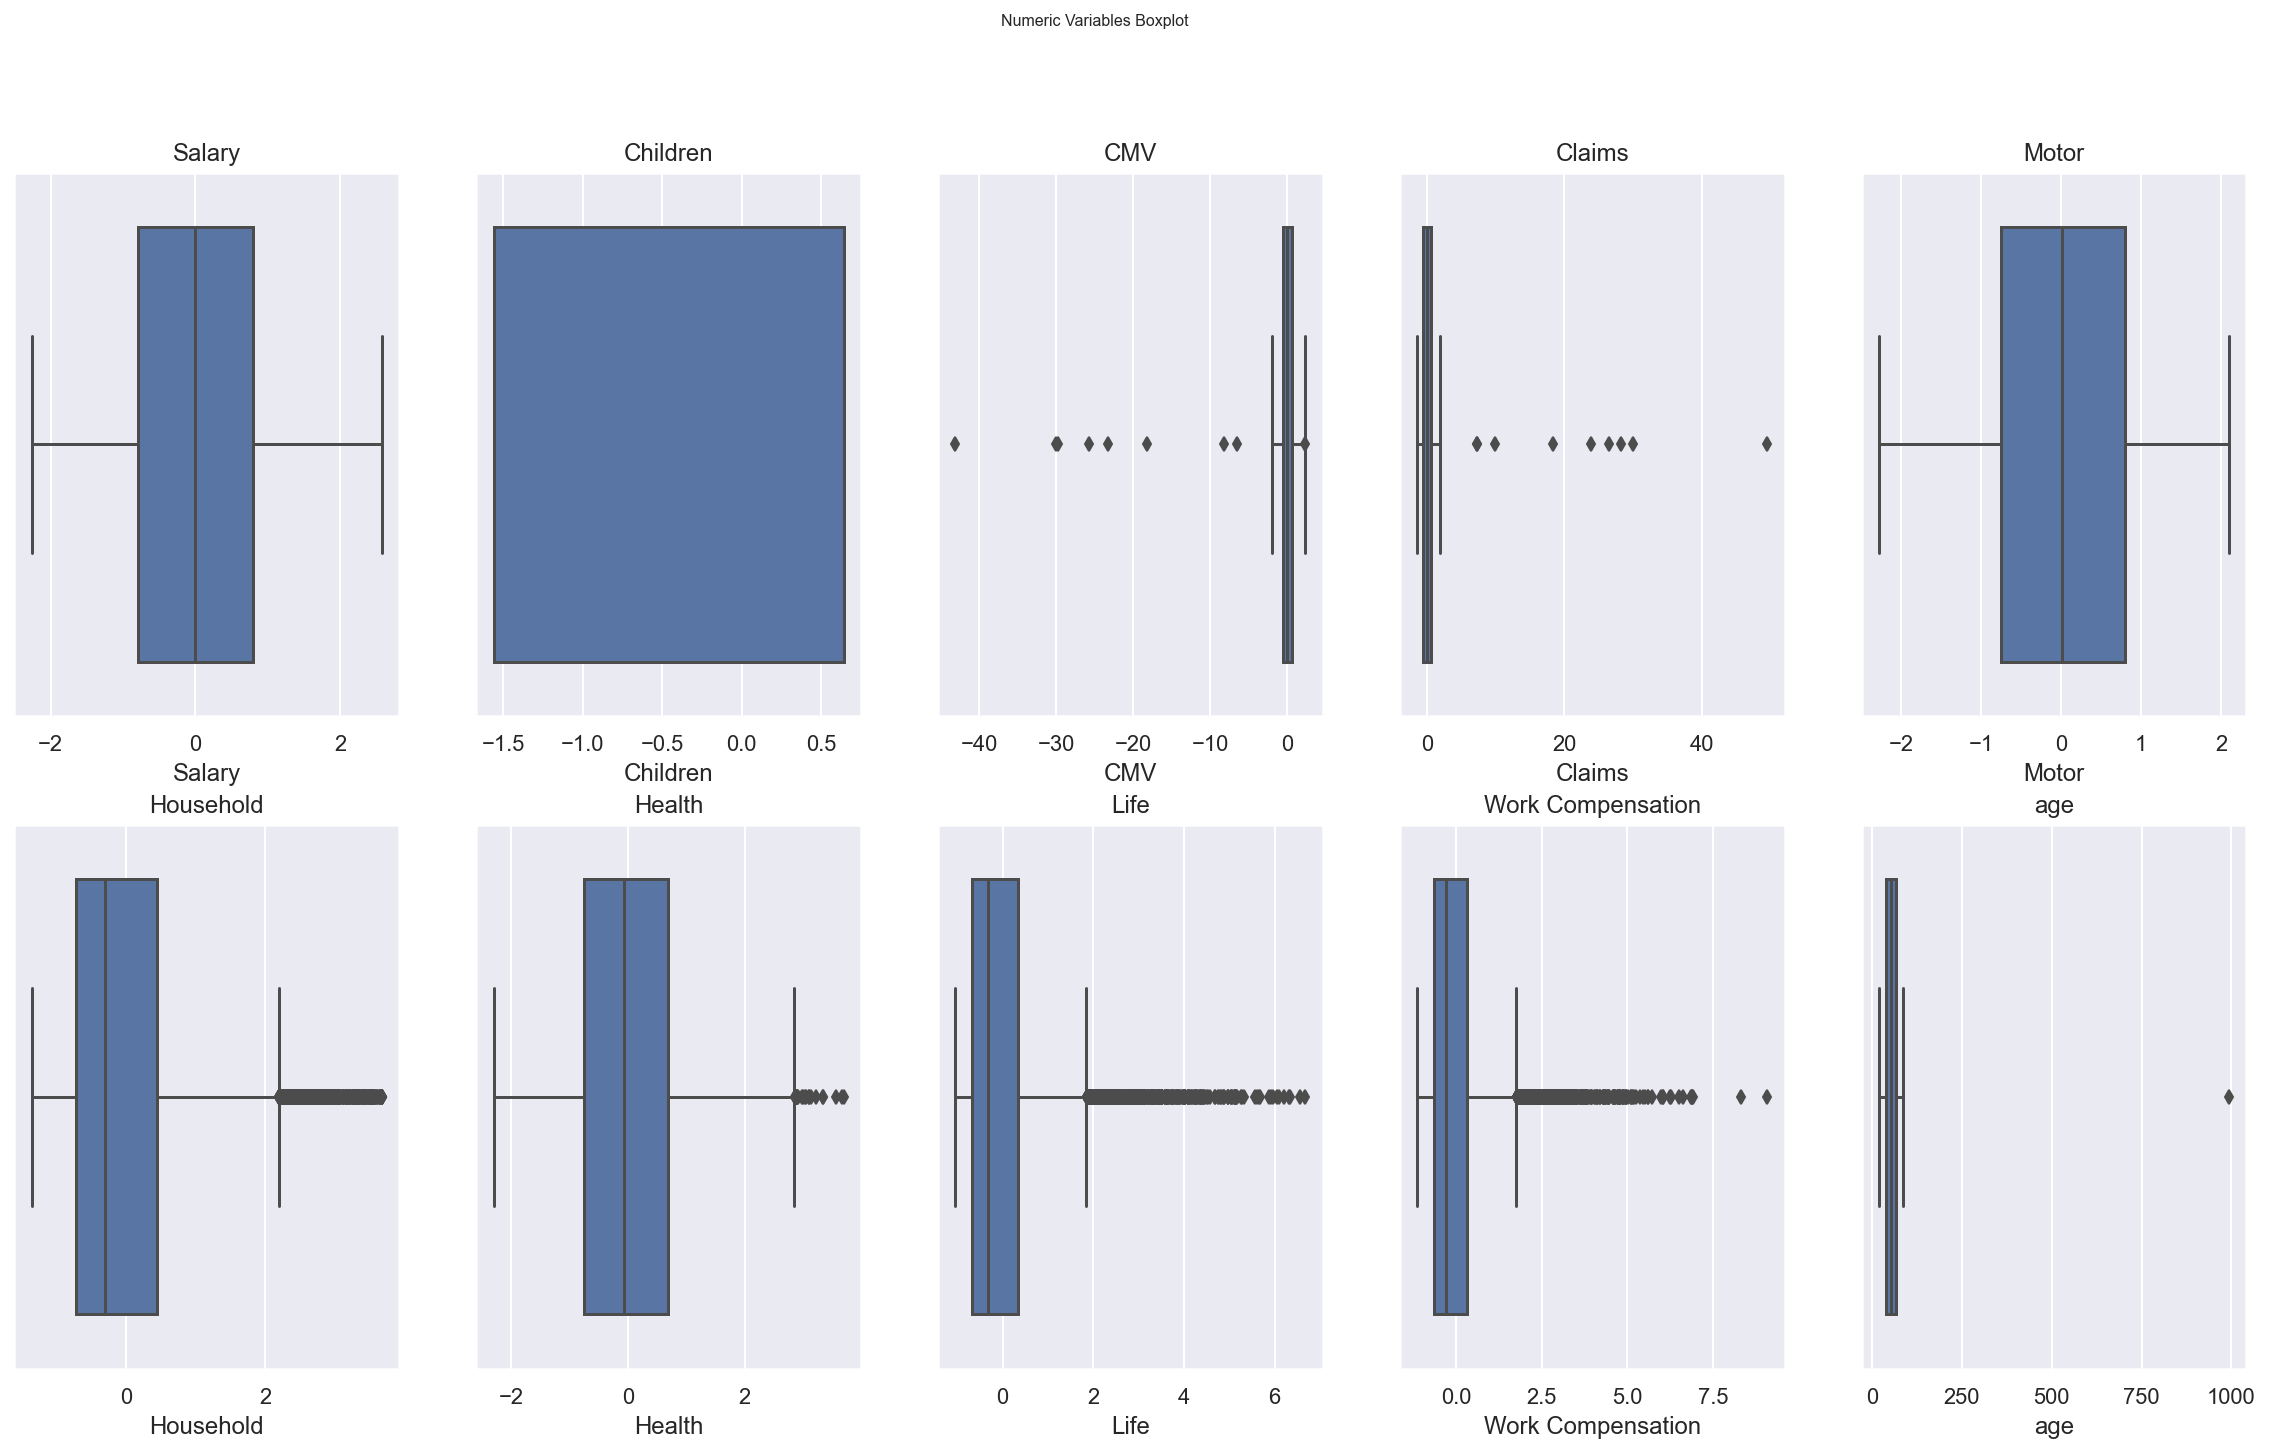

In [244]:
# All Numeric Variables' Histograms in one figure
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    sns.boxplot(df[feat], ax = ax)
    ax.set_title(feat)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables Boxplot"

plt.suptitle(title)

plt.show()

# Barplots of Categorical Features

In [29]:
df['Education'].value_counts()

3 - BSc/MSc        4799
2 - High School    3510
1 - Basic          1272
4 - PhD             698
Name: Education, dtype: int64

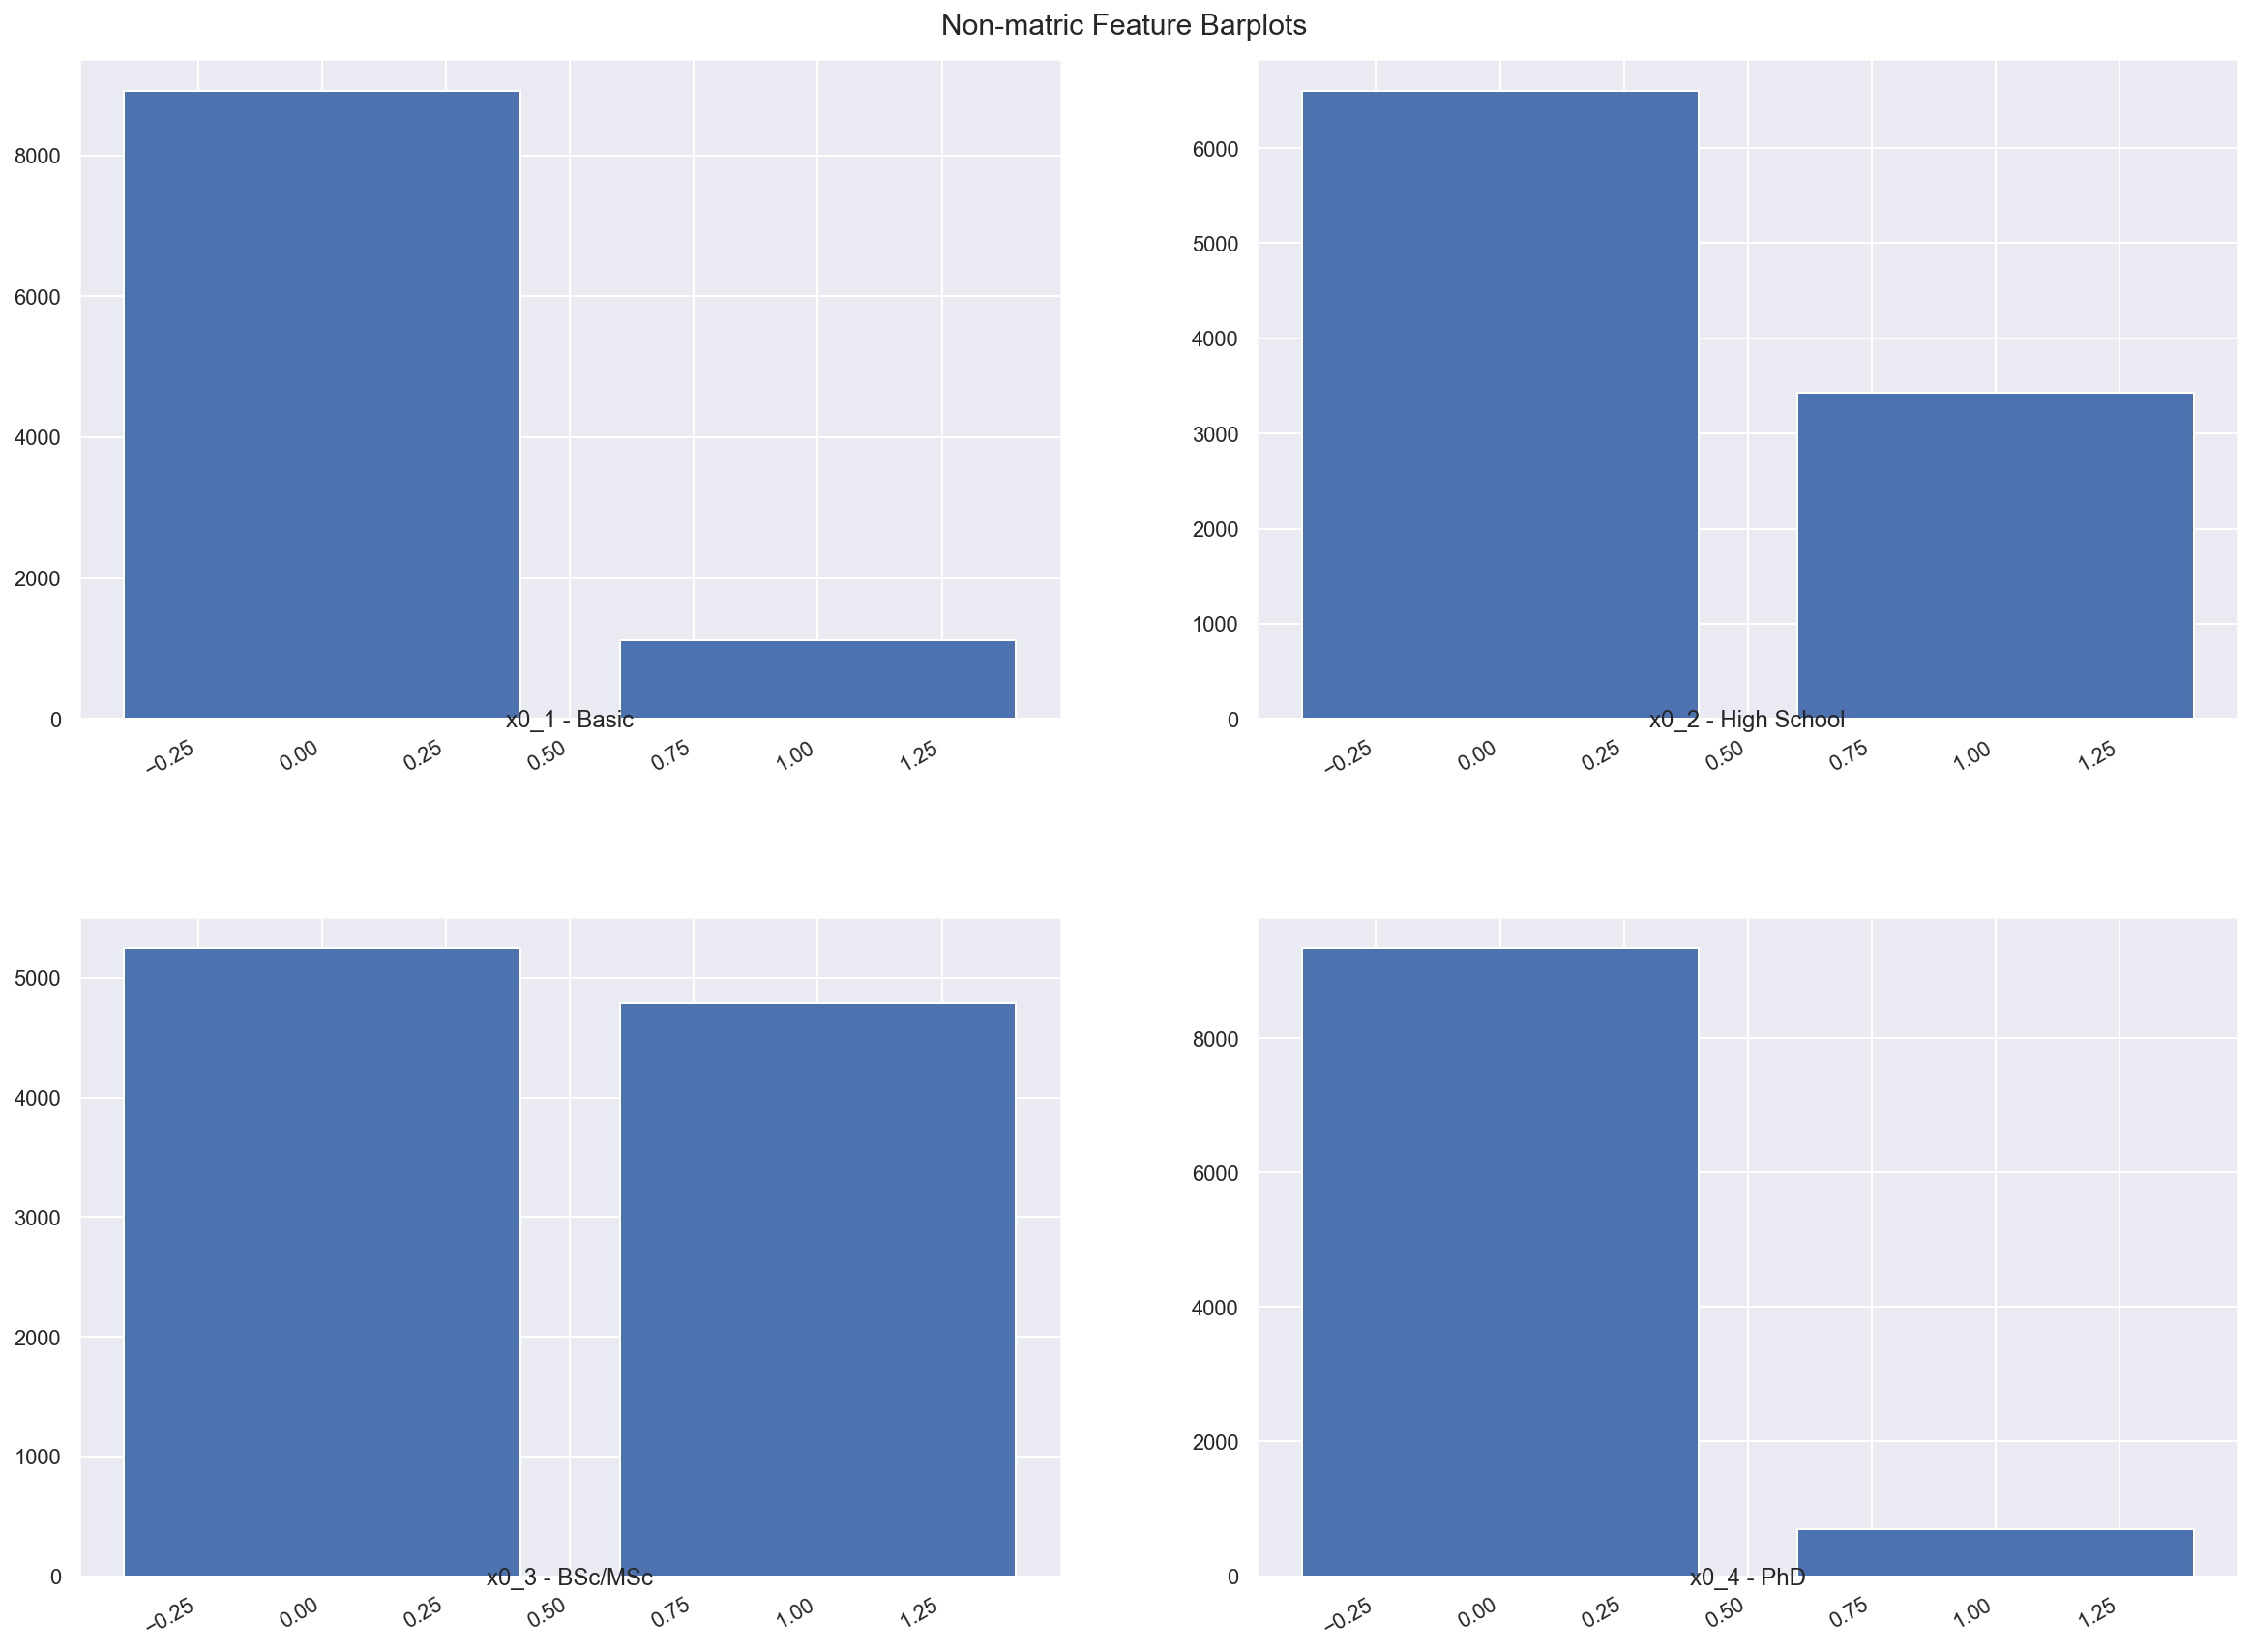

In [245]:
# All Non-numeric Variables' Barplots in one figure
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(2, ceil(len(non_metric_features) / 2), figsize=(20, 11))


# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), non_metric_features): # Notice the zip() function and flatten() method
    ax.bar(df[feat].value_counts().index,df[feat].value_counts().values)
    ax.set_title(feat, y=-0.03)
    #labels rotation
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
    
# Layout
# Add a centered title to the figure:
title = "Non-matric Feature Barplots"
plt.suptitle(title, y=1.03, fontsize=15)
# Space in betweeen rows
plt.subplots_adjust(top = 1.00, bottom=0.01, hspace=0.3,)

plt.show();

In [31]:
# let's keep the central imputation
df = df_central.copy()

# Outlier removal

In [32]:
# This may vary from session to session, and is prone to varying interpretations.
# A simple example is provided below:

filters1 = (
    (df['Salary']<=6000)
    &
    (df['CMV']<=1000)
    &
    (df['Claims']<=30)
    &
    (df['Motor']<=1200)
    &
    (df['Household']<=900)
    &
    (df['Health']<=900)
    &
    (df['Life']<=350)
        
)

df_1 = df[filters1]

In [33]:
print('Percentage of data kept after removing outliers:', np.round(df_1.shape[0] / df_original.shape[0], 4))

Percentage of data kept after removing outliers: 0.9745


In [34]:
print('The proportion of records excluded is', np.round(1-((df_1.shape[0] / df_original.shape[0])), 4))

The proportion of records excluded is 0.0255


# Outlier removal using only the IQR method

In [35]:
q25 = df.quantile(.25)
q75 = df.quantile(.75)
iqr = (q75 - q25)

upper_lim = q75 + 1.5 * iqr
lower_lim = q25 - 1.5 * iqr

filters2 = []
for metric in metric_features:
    llim = lower_lim[metric]
    ulim = upper_lim[metric]
    filters2.append(df[metric].between(llim, ulim, inclusive=True))

filters2 = pd.Series(np.all(filters2, 0))
df_2 = df[filters2]
print('Percentage of data kept after removing outliers:', np.round(df_2.shape[0] / df_original.shape[0], 4))

Percentage of data kept after removing outliers: 0.8538


# Combining different outlier methods

In [36]:
df_3 = df[(filters1 | filters2)]
print('Percentage of data kept after removing outliers:', np.round(df_3.shape[0] / df_original.shape[0], 4))

Percentage of data kept after removing outliers: 0.9746


In [37]:
# Get the manual filtering version
df = df_3.copy()

# Feature Engineering

In [39]:
df['age'] = df['Birthday']
df['Birthday'] = datetime.now().year - df['age']
df['age']

0        39.0
1        26.0
2        51.0
3        40.0
4        48.0
         ... 
10290    22.0
10291    72.0
10293    45.0
10294    44.0
10295    40.0
Name: age, Length: 10034, dtype: float64

# Correlations Matricx

In [40]:
def cor_heatmap(cor):
    plt.figure(figsize=(12,10))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Blues, fmt='.1')
    plt.show()

In [41]:
cor_spearman = df_3.corr(method ='spearman')
cor_spearman

ID  First Policy  Birthday    Salary      Area  \
ID                 1.000000     -0.013717  0.014508 -0.017246 -0.006161   
First Policy      -0.013717      1.000000 -0.016311  0.019848 -0.004155   
Birthday           0.014508     -0.016311  1.000000 -0.927563 -0.014392   
Salary            -0.017246      0.019848 -0.927563  1.000000  0.011123   
Area              -0.006161     -0.004155 -0.014392  0.011123  1.000000   
Children           0.000399     -0.011883  0.507124 -0.475095 -0.024118   
CMV               -0.008432      0.012982  0.018907 -0.014783 -0.006784   
Claims             0.015033     -0.010979  0.003640 -0.004503  0.008823   
Motor             -0.014764     -0.017478 -0.183758  0.167488 -0.006478   
Household          0.015981      0.012280  0.130403 -0.117958  0.010862   
Health             0.001926      0.009622 -0.010882  0.006665  0.005332   
Life               0.010785      0.011403  0.139687 -0.123591  0.010949   
Work Compensation  0.016938      0.015234  0.151023 -0.135551  0.010570   

                   Children       CMV    Claims     Motor  Household  \
ID                 0.000399 -0.008432  0.015033 -0.014764   0.015981   
First Policy      -0.011883  0.012982 -0.010979 -0.017478   0.012280   
Birthday           0.507124  0.018907  0.003640 -0.183758   0.130403   
Salary            -0.475095 -0.014783 -0.004503  0.167488  -0.117958   
Area              -0.024118 -0.006784  0.008823 -0.006478   0.010862   
Children           1.000000  0.011492 -0.032834  0.266164  -0.144077   
CMV                0.011492  1.000000 -0.972093  0.004287   0.187827   
Claims            -0.032834 -0.972093  1.000000 -0.105334  -0.037549   
Motor              0.266164  0.004287 -0.105334  1.000000  -0.649935   
Household         -0.144077  0.187827 -0.037549 -0.649935   1.000000   
Health            -0.275710 -0.076052  0.116872 -0.692431   0.270733   
Life              -0.163938 -0.001677  0.072210 -0.698471   0.463708   
Work Compensation -0.131639  0.011308  0.061370 -0.678929   0.453788   

                     Health      Life  Work Compensation  
ID                 0.001926  0.010785           0.016938  
First Policy       0.009622  0.011403           0.015234  
Birthday          -0.010882  0.139687           0.151023  
Salary             0.006665 -0.123591          -0.135551  
Area               0.005332  0.010949           0.010570  
Children          -0.275710 -0.163938          -0.131639  
CMV               -0.076052 -0.001677           0.011308  
Claims             0.116872  0.072210           0.061370  
Motor             -0.692431 -0.698471          -0.678929  
Household          0.270733  0.463708           0.453788  
Health             1.000000  0.284743           0.280933  
Life               0.284743  1.000000           0.478493  
Work Compensation  0.280933  0.478493           1.000000

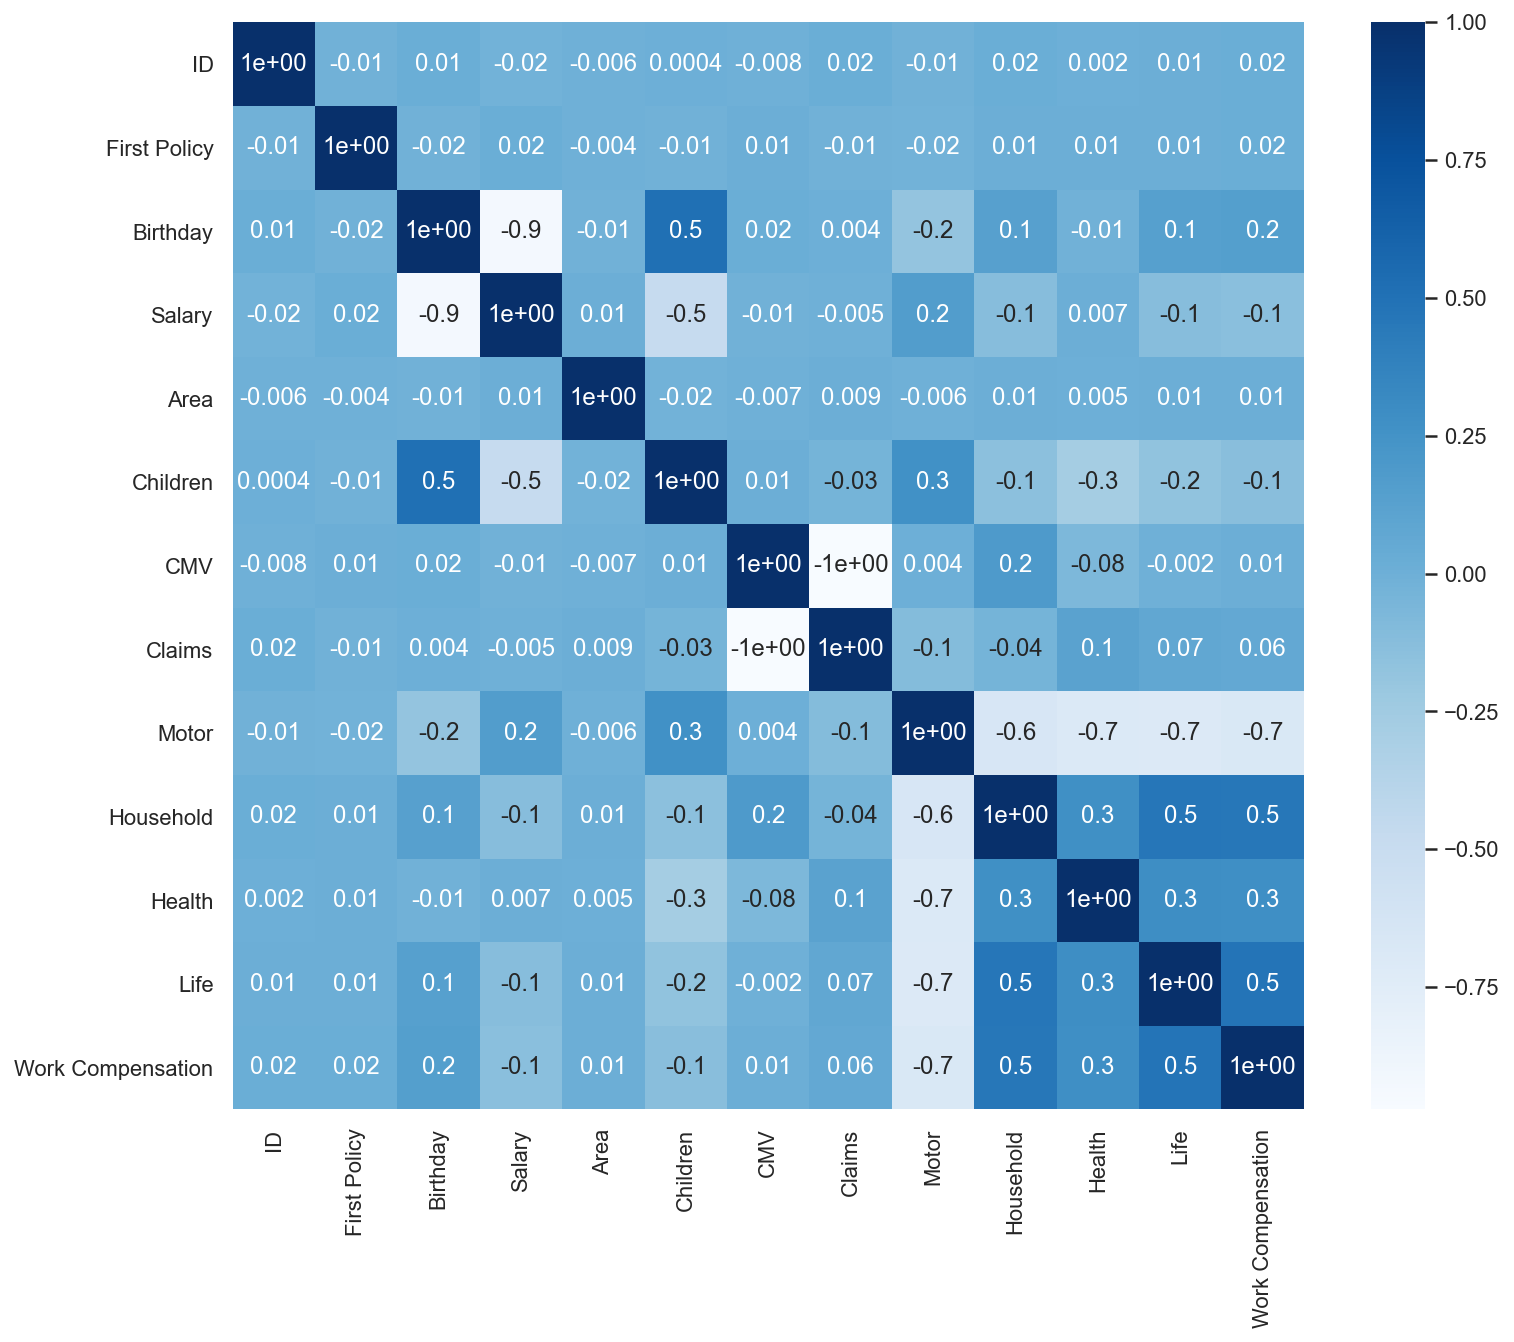

In [246]:
# DO IT
cor_heatmap(cor_spearman)

# Variable selection: Redundancy VS Relevancy

In [43]:
# Select variables according to their correlations
df.drop(columns=['Birthday', 'ID', 'First Policy','Area'], inplace=True)

In [44]:
# Updating metric_features
metric_features.remove('Birthday')
metric_features.remove('ID')
metric_features.remove('First Policy')
metric_features.remove('Area')

# Data Normalization

In [45]:
df_minmax = df.copy()

In [46]:
# Use MinMaxScaler to scale the data
scaler = MinMaxScaler()
scaled_feat = scaler.fit_transform(df_minmax[metric_features])
scaled_feat

array([[0.39334471, 1.        , 0.9603842 , ..., 0.33366294, 0.15282965,
        0.06232606],
       [0.07337884, 1.        , 0.92780314, ..., 0.26698429, 0.57011885,
        0.25484866],
       [0.41467577, 0.        , 0.9682543 , ..., 0.28471582, 0.26414827,
        0.23950985],
       ...,
       [0.55140785, 1.        , 0.96949049, ..., 0.32442637, 0.05565931,
        0.03643777],
       [0.34940273, 1.        , 0.95205475, ..., 0.45054723, 0.20062252,
        0.26947555],
       [0.52943686, 1.        , 0.96565087, ..., 0.32217902, 0.0393039 ,
        0.05369663]])

In [47]:
# See what the fit method is doing (notice the trailing underscore):
print("Parameters fitted:\n", scaler.data_min_, "\n", scaler.data_max_)

Parameters fitted:
 [ 3.330000e+02  0.000000e+00 -1.471408e+04  0.000000e+00 -4.110000e+00
 -7.500000e+01 -2.110000e+00 -7.000000e+00 -1.200000e+01] 
 [5.02100e+03 1.00000e+00 1.00364e+03 2.53600e+01 5.85220e+02 8.99050e+02
 4.42860e+02 3.46400e+02 4.51530e+02]


In [48]:
df_minmax[metric_features] = scaled_feat
df_minmax.head()

Education    Salary  Children       CMV    Claims     Motor  \
0  2 - High School  0.393345       1.0  0.960384  0.015379  0.644732   
1  2 - High School  0.073379       1.0  0.927803  0.044164  0.138411   
2        1 - Basic  0.414676       0.0  0.968254  0.011041  0.356778   
3      3 - BSc/MSc  0.163396       1.0  0.935065  0.039038  0.316614   
4      3 - BSc/MSc  0.305034       1.0  0.938387  0.035489  0.581559   

   Household    Health      Life  Work Compensation   age  
0   0.158565  0.333663  0.152830           0.062326  39.0  
1   0.504286  0.266984  0.570119           0.254849  26.0  
2   0.307479  0.284716  0.264148           0.239510  51.0  
3   0.121503  0.704047  0.119808           0.087028  40.0  
4   0.126072  0.415084  0.072949           0.115311  48.0

In [49]:
# Checking max and min of minmaxed variables
df_minmax[metric_features].describe().round(2)

Salary  Children       CMV    Claims     Motor  Household    Health  \
count  10034.00  10034.00  10034.00  10034.00  10034.00   10034.00  10034.00   
mean       0.47      0.71      0.95      0.03      0.52       0.27      0.38   
std        0.21      0.45      0.02      0.02      0.23       0.20      0.17   
min        0.00      0.00      0.00      0.00      0.00       0.00      0.00   
25%        0.30      0.00      0.94      0.02      0.35       0.13      0.26   
50%        0.47      1.00      0.95      0.03      0.52       0.21      0.37   
75%        0.63      1.00      0.96      0.04      0.70       0.36      0.50   
max        1.00      1.00      1.00      1.00      1.00       1.00      1.00   

           Life  Work Compensation  
count  10034.00           10034.00  
mean       0.13               0.11  
std        0.13               0.10  
min        0.00               0.00  
25%        0.05               0.05  
50%        0.09               0.08  
75%        0.18               0.14  
max        1.00               1.00

In [50]:
df_standard = df.copy()

In [51]:
scaler = StandardScaler()
scaled_feat = scaler.fit_transform(df_standard[metric_features])
scaled_feat

array([[-0.35816621,  0.6414439 ,  0.51495829, ..., -0.30342227,
         0.14062536, -0.50287617],
       [-1.90586526,  0.6414439 , -0.9637638 , ..., -0.70311682,
         3.35959354,  1.46660032],
       [-0.25498627, -1.55898279,  0.87215009, ..., -0.59682797,
         0.99933702,  1.30968663],
       ...,
       [ 0.40639712,  0.6414439 ,  0.92825548, ..., -0.35878946,
        -0.60894654, -0.7677094 ],
       [-0.57071688,  0.6414439 ,  0.13691827, ...,  0.39722192,
         0.50929948,  1.6162311 ],
       [ 0.30012179,  0.6414439 ,  0.75399093, ..., -0.3722608 ,
        -0.73511211, -0.59115391]])

In [52]:
# See what the fit method is doing (notice the trailing underscore):
print("Parameters fitted:\n", scaler.mean_, "\n", scaler.var_)

Parameters fitted:
 [2.52412777e+03 7.08491130e-01 2.02633488e+02 6.92763604e-01
 3.02300043e+02 1.86185041e+02 1.68883547e+02 4.05675563e+01
 3.96760903e+01] 
 [9.39311163e+05 2.06531449e-01 1.19932373e+05 2.47815733e-01
 1.82030278e+04 3.76866965e+04 5.51034325e+03 2.09881419e+03
 2.05313507e+03]


In [53]:
df_standard[metric_features] = scaled_feat
df_standard.head()

Education    Salary  Children       CMV    Claims     Motor  \
0  2 - High School -0.358166  0.641444  0.514958 -0.608190  0.545143   
1  2 - High School -1.905865  0.641444 -0.963764  0.858230 -1.666487   
2        1 - Basic -0.254986 -1.558983  0.872150 -0.829157 -0.712652   
3      3 - BSc/MSc -1.470446  0.641444 -0.634177  0.597087 -0.888091   
4      3 - BSc/MSc -0.785331  0.641444 -0.483388  0.416295  0.269199   

   Household    Health      Life  Work Compensation   age  
0  -0.549810 -0.303422  0.140625          -0.502876  39.0  
1   1.184846 -0.703117  3.359594           1.466600  26.0  
2   0.197367 -0.596828  0.999337           1.309687  51.0  
3  -0.735768  1.916789 -0.114107          -0.250181  40.0  
4  -0.712845  0.184644 -0.475578           0.039149  48.0

In [54]:
# Checking mean and variance of standardized variables
df_standard[metric_features].describe().round(2)

Salary  Children       CMV    Claims     Motor  Household    Health  \
count  10034.00  10034.00  10034.00  10034.00  10034.00   10034.00  10034.00   
mean       0.00     -0.00      0.00     -0.00      0.00       0.00      0.00   
std        1.00      1.00      1.00      1.00      1.00       1.00      1.00   
min       -2.26     -1.56    -43.07     -1.39     -2.27      -1.35     -2.30   
25%       -0.79     -1.56     -0.61     -0.59     -0.75      -0.71     -0.75   
50%       -0.00      0.64     -0.05      0.05      0.01      -0.30     -0.07   
75%        0.80      0.64      0.55      0.58      0.79       0.45      0.69   
max        2.58      0.64      2.31     49.55      2.10       3.67      3.69   

           Life  Work Compensation  
count  10034.00           10034.00  
mean      -0.00              -0.00  
std        1.00               1.00  
min       -1.04              -1.14  
25%       -0.67              -0.64  
50%       -0.33              -0.31  
75%        0.33               0.32  
max        6.68               9.09

In [55]:
df = df_standard.copy()

# One-hot encoding

In [56]:
df_ohc = df.copy()

In [57]:
# Use OneHotEncoder to encode the categorical features. Get feature names and create a DataFrame 
# with the one-hot encoded categorical features (pass feature names)
ohc = OneHotEncoder(sparse=False)
ohc_feat = ohc.fit_transform(df_ohc[non_metric_features])
ohc_feat_names = ohc.get_feature_names()
ohc_df = pd.DataFrame(ohc_feat, index=df_ohc.index, columns=ohc_feat_names)  # Why the index=df_ohc.index?
ohc_df.head(15)

C:\Users\foazu\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


x0_1 - Basic  x0_2 - High School  x0_3 - BSc/MSc  x0_4 - PhD
0            0.0                 1.0             0.0         0.0
1            0.0                 1.0             0.0         0.0
2            1.0                 0.0             0.0         0.0
3            0.0                 0.0             1.0         0.0
4            0.0                 0.0             1.0         0.0
5            0.0                 1.0             0.0         0.0
6            0.0                 1.0             0.0         0.0
7            0.0                 1.0             0.0         0.0
8            0.0                 0.0             1.0         0.0
9            0.0                 0.0             1.0         0.0
10           0.0                 0.0             1.0         0.0
11           0.0                 0.0             1.0         0.0
12           0.0                 0.0             1.0         0.0
13           1.0                 0.0             0.0         0.0
14           0.0                 1.0             0.0         0.0

In [58]:
# Reassigning df to contain ohc variables
df_ohc = pd.concat([df_ohc.drop(columns=non_metric_features), ohc_df], axis=1)
df_ohc.head()

Salary  Children       CMV    Claims     Motor  Household    Health  \
0 -0.358166  0.641444  0.514958 -0.608190  0.545143  -0.549810 -0.303422   
1 -1.905865  0.641444 -0.963764  0.858230 -1.666487   1.184846 -0.703117   
2 -0.254986 -1.558983  0.872150 -0.829157 -0.712652   0.197367 -0.596828   
3 -1.470446  0.641444 -0.634177  0.597087 -0.888091  -0.735768  1.916789   
4 -0.785331  0.641444 -0.483388  0.416295  0.269199  -0.712845  0.184644   

       Life  Work Compensation   age  x0_1 - Basic  x0_2 - High School  \
0  0.140625          -0.502876  39.0           0.0                 1.0   
1  3.359594           1.466600  26.0           0.0                 1.0   
2  0.999337           1.309687  51.0           1.0                 0.0   
3 -0.114107          -0.250181  40.0           0.0                 0.0   
4 -0.475578           0.039149  48.0           0.0                 0.0   

   x0_3 - BSc/MSc  x0_4 - PhD  
0             0.0         0.0  
1             0.0         0.0  
2             0.0         0.0  
3             1.0         0.0  
4             1.0         0.0

In [59]:
df = df_ohc.copy()

# Dimensionality Reduction: PCA

In [60]:
df_pca = df.copy()

# A more specific explanation of PCA

In [61]:
# Use PCA to reduce dimensionality of data
pca = PCA()
pca_feat = pca.fit_transform(df_pca[metric_features])
pca_feat  # What is this output?

array([[-8.58819080e-01, -7.87878604e-01,  6.06630304e-01, ...,
        -1.09420264e-01,  1.52353004e-02, -8.36246538e-02],
       [ 3.48436671e+00,  8.47873461e-01,  2.60360753e+00, ...,
         1.80695669e-03, -1.97996243e-01,  3.81424242e-02],
       [ 1.51890713e+00, -1.25113545e+00, -5.25793965e-01, ...,
         9.04131488e-01,  4.34910804e-03,  1.64594615e-01],
       ...,
       [-1.43505495e+00, -1.31375726e+00, -3.51202186e-02, ...,
        -4.30912294e-01,  6.62632481e-03, -5.00777871e-03],
       [ 1.52598261e+00, -2.21241566e-01,  8.93055789e-01, ...,
        -4.30483650e-01,  4.21612691e-02, -9.33086541e-02],
       [-1.52614645e+00, -1.09368521e+00,  6.49067231e-02, ...,
        -3.38801123e-01, -7.18211520e-03, -3.19521813e-02]])

In [62]:
pca_feat.shape

(10034, 9)

In [63]:
len(metric_features)

9

In [64]:
# Output PCA table
pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
     "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1)
)

Eigenvalue  Difference  Proportion  Cumulative
1    2.924770    0.000000    0.324942    0.324942
2    1.997866   -0.926905    0.221963    0.546905
3    1.569298   -0.428567    0.174349    0.721254
4    0.904956   -0.664342    0.100541    0.821795
5    0.594283   -0.310673    0.066025    0.887820
6    0.573335   -0.020948    0.063698    0.951517
7    0.404292   -0.169044    0.044917    0.996434
8    0.021955   -0.382336    0.002439    0.998873
9    0.010141   -0.011814    0.001127    1.000000

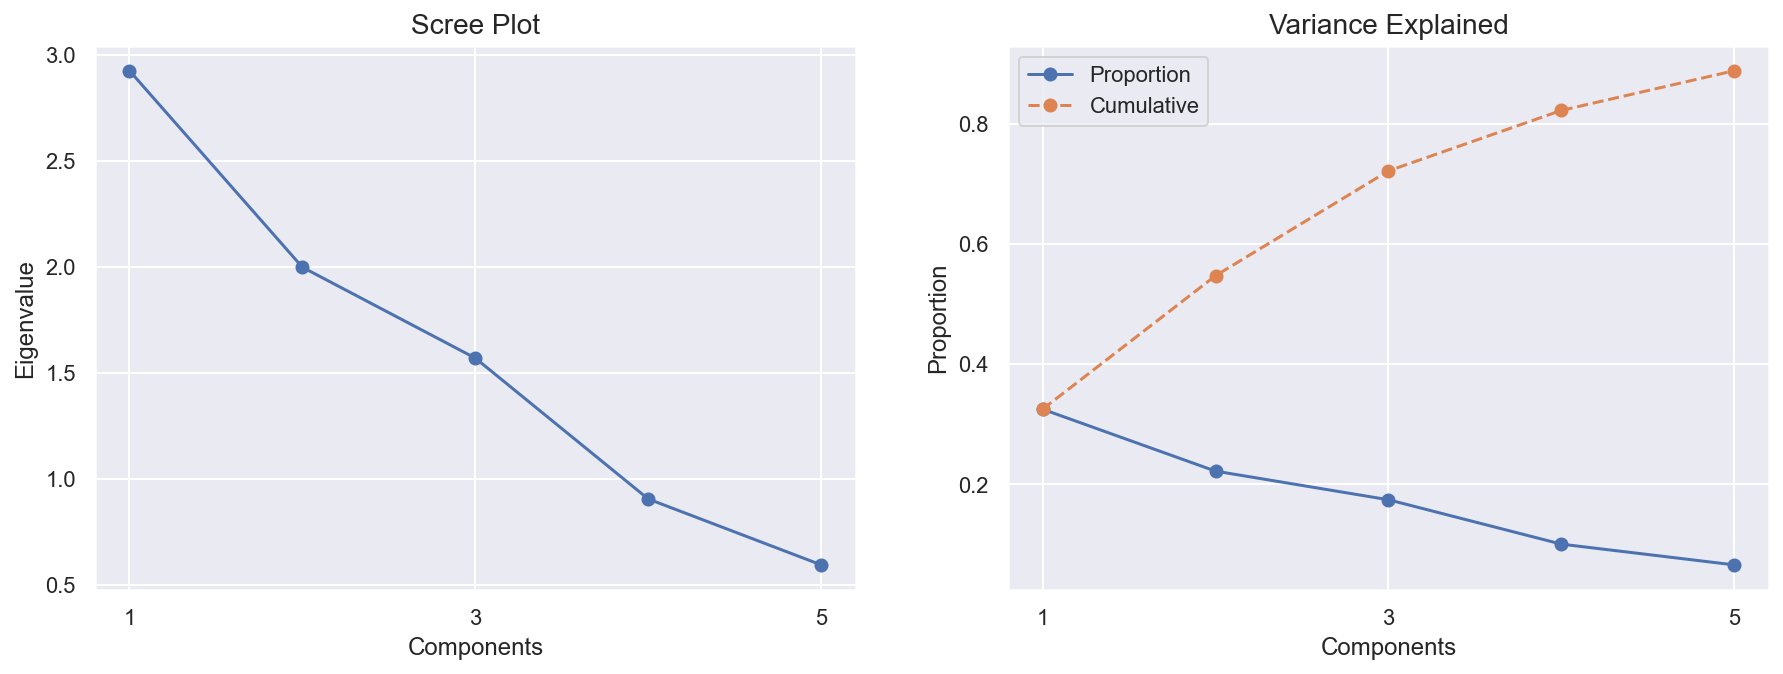

In [247]:
# figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# draw plots
ax1.plot(pca.explained_variance_, marker=".", markersize=12)
ax2.plot(pca.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
ax2.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")

# customizations
ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, pca.n_components_, 2))
ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca.n_components_, 2))
ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))

plt.show()

In [66]:
# Perform PCA again with the number of principal components you want to retain
pca = PCA(n_components=5)
pca_feat = pca.fit_transform(df_pca[metric_features])
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_feat, index=df_pca.index, columns=pca_feat_names)  # remember index=df_pca.index
pca_df.head(10)

PC0       PC1       PC2       PC3       PC4
0 -0.858819 -0.787879  0.606630 -0.228414 -0.293450
1  3.484367  0.847873  2.603608  1.377429 -0.933332
2  1.518907 -1.251135 -0.525794  1.264809  0.550912
3  0.785296  1.074083  0.717595 -2.385903  0.072725
4 -0.546414  0.669573  0.865091 -0.707944  0.447345
5 -1.858168  0.902093  0.547912  0.068747  0.003356
6  1.141062  1.370859 -2.735384 -0.901578 -0.062391
7  1.006787  1.050899  1.342325  0.395995 -0.468570
8 -0.964860 -0.643726  0.388824 -1.394934  0.106964
9  1.018411  1.540773 -2.192003 -0.182842  0.346194

In [67]:
# Reassigning df to contain pca variables
df_pca = pd.concat([df_pca, pca_df], axis=1)
df_pca.head()

Salary  Children       CMV    Claims     Motor  Household    Health  \
0 -0.358166  0.641444  0.514958 -0.608190  0.545143  -0.549810 -0.303422   
1 -1.905865  0.641444 -0.963764  0.858230 -1.666487   1.184846 -0.703117   
2 -0.254986 -1.558983  0.872150 -0.829157 -0.712652   0.197367 -0.596828   
3 -1.470446  0.641444 -0.634177  0.597087 -0.888091  -0.735768  1.916789   
4 -0.785331  0.641444 -0.483388  0.416295  0.269199  -0.712845  0.184644   

       Life  Work Compensation   age  x0_1 - Basic  x0_2 - High School  \
0  0.140625          -0.502876  39.0           0.0                 1.0   
1  3.359594           1.466600  26.0           0.0                 1.0   
2  0.999337           1.309687  51.0           1.0                 0.0   
3 -0.114107          -0.250181  40.0           0.0                 0.0   
4 -0.475578           0.039149  48.0           0.0                 0.0   

   x0_3 - BSc/MSc  x0_4 - PhD       PC0       PC1       PC2       PC3  \
0             0.0         0.0 -0.858819 -0.787879  0.606630 -0.228414   
1             0.0         0.0  3.484367  0.847873  2.603608  1.377429   
2             0.0         0.0  1.518907 -1.251135 -0.525794  1.264809   
3             1.0         0.0  0.785296  1.074083  0.717595 -2.385903   
4             1.0         0.0 -0.546414  0.669573  0.865091 -0.707944   

        PC4  
0 -0.293450  
1 -0.933332  
2  0.550912  
3  0.072725  
4  0.447345

# How do we interpret each Principal Component (with style)?

In [68]:
df_pca[metric_features + pca_feat_names].corr().loc[metric_features, pca_feat_names]

PC0       PC1       PC2       PC3       PC4
Salary            -0.258789  0.073780 -0.810346  0.282933  0.023763
Children          -0.268342 -0.064240  0.818320 -0.236506 -0.005440
CMV                0.016900 -0.988388 -0.095716 -0.051510  0.000230
Claims             0.089595  0.975815  0.104552  0.080352 -0.038767
Motor             -0.975861 -0.019936  0.083794  0.159169 -0.015171
Household          0.720365 -0.182213  0.070188  0.186681 -0.254920
Health             0.529525  0.154315 -0.392178 -0.730981  0.015306
Life               0.723286 -0.020634  0.156833  0.301434 -0.375253
Work Compensation  0.708813 -0.033652  0.179984  0.272744  0.621179

In [69]:
def _color_red_or_green(val):
    if val < -0.45:
        color = 'background-color: red'
    elif val > 0.45:
        color = 'background-color: green'
    else:
        color = ''
    return color

# Interpreting each Principal Component
loadings = df_pca[metric_features + pca_feat_names].corr().loc[metric_features, pca_feat_names]
loadings.style.applymap(_color_red_or_green)

# Import preprocessed data

In [70]:
df_preprocessed = df_pca.copy()
df_preprocessed.head(10)

Salary  Children       CMV    Claims     Motor  Household    Health  \
0 -0.358166  0.641444  0.514958 -0.608190  0.545143  -0.549810 -0.303422   
1 -1.905865  0.641444 -0.963764  0.858230 -1.666487   1.184846 -0.703117   
2 -0.254986 -1.558983  0.872150 -0.829157 -0.712652   0.197367 -0.596828   
3 -1.470446  0.641444 -0.634177  0.597087 -0.888091  -0.735768  1.916789   
4 -0.785331  0.641444 -0.483388  0.416295  0.269199  -0.712845  0.184644   
5  0.043204  0.641444 -0.655372  0.617175  1.026174  -0.861714 -0.728578   
6  1.629079 -1.558983 -0.775726  0.717615 -1.077539   0.563615  2.008124   
7 -0.805967  0.641444 -1.003554  0.878318 -0.400464   1.087489 -0.330365   
8 -0.683183  0.641444  0.444386 -0.668454  0.312855  -0.864547  0.554432   
9  1.359780 -1.558983 -0.929748  0.858230 -0.689601  -0.020270  1.388308   

       Life  Work Compensation   age  x0_1 - Basic  x0_2 - High School  \
0  0.140625          -0.502876  39.0           0.0                 1.0   
1  3.359594           1.466600  26.0           0.0                 1.0   
2  0.999337           1.309687  51.0           1.0                 0.0   
3 -0.114107          -0.250181  40.0           0.0                 0.0   
4 -0.475578           0.039149  48.0           0.0                 0.0   
5 -0.732711          -0.706356  65.0           0.0                 1.0   
6 -0.565291          -0.294320  78.0           0.0                 1.0   
7  0.569981           0.299127  47.0           0.0                 1.0   
8 -0.693857          -0.657362  43.0           0.0                 0.0   
9 -0.029196           0.340838  73.0           0.0                 0.0   

   x0_3 - BSc/MSc  x0_4 - PhD       PC0       PC1       PC2       PC3  \
0             0.0         0.0 -0.858819 -0.787879  0.606630 -0.228414   
1             0.0         0.0  3.484367  0.847873  2.603608  1.377429   
2             0.0         0.0  1.518907 -1.251135 -0.525794  1.264809   
3             1.0         0.0  0.785296  1.074083  0.717595 -2.385903   
4             1.0         0.0 -0.546414  0.669573  0.865091 -0.707944   
5             0.0         0.0 -1.858168  0.902093  0.547912  0.068747   
6             0.0         0.0  1.141062  1.370859 -2.735384 -0.901578   
7             0.0         0.0  1.006787  1.050899  1.342325  0.395995   
8             1.0         0.0 -0.964860 -0.643726  0.388824 -1.394934   
9             1.0         0.0  1.018411  1.540773 -2.192003 -0.182842   

        PC4  
0 -0.293450  
1 -0.933332  
2  0.550912  
3  0.072725  
4  0.447345  
5  0.003356  
6 -0.062391  
7 -0.468570  
8  0.106964  
9  0.346194

In [71]:
df_preprocessed.columns

Index(['Salary', 'Children', 'CMV', 'Claims', 'Motor', 'Household', 'Health',
       'Life', 'Work Compensation', 'age', 'x0_1 - Basic',
       'x0_2 - High School', 'x0_3 - BSc/MSc', 'x0_4 - PhD', 'PC0', 'PC1',
       'PC2', 'PC3', 'PC4'],
      dtype='object')

In [72]:
# Splitting feature names into groups
non_metric_features = df_preprocessed.columns[df_preprocessed.columns.str.startswith('x')]
pc_features = df_preprocessed.columns[df_preprocessed.columns.str.startswith('PC')]
metric_features = df_preprocessed.columns[~df_preprocessed.columns.str.startswith('x') & ~df_preprocessed.columns.str.startswith('PC')]

# Hierarchical Clustering

In [73]:
# Performing HC
hclust = AgglomerativeClustering(linkage='ward', affinity='euclidean', n_clusters=5)
hc_labels = hclust.fit_predict(df_preprocessed[metric_features])
hc_labels

array([1, 4, 1, ..., 1, 1, 1], dtype=int64)

In [74]:
np.unique(hc_labels)

array([0, 1, 2, 3, 4], dtype=int64)

In [75]:
# Characterizing the clusters
df_concat = pd.concat((df_preprocessed, pd.Series(hc_labels, name='labels')), axis=1)
df_concat.groupby('labels').mean()

Salary  Children       CMV    Claims     Motor  Household    Health  \
labels                                                                          
0.0     0.016345 -0.003046  0.010391 -0.010438  0.006755  -0.001412 -0.016124   
1.0    -0.027070  0.028282 -0.033353  0.046709  0.002243   0.001630  0.008457   
2.0    -1.085585  0.641444  0.178326 -0.186343  0.058331  -0.269329  0.569386   
3.0    -0.007602 -0.029327  0.013106 -0.010579 -0.035749   0.011258  0.018596   
4.0     0.021240 -0.016179  0.002879 -0.021018  0.005833  -0.001568  0.005186   

            Life  Work Compensation        age  x0_1 - Basic  \
labels                                                         
0.0     0.000319           0.009312  53.585787      0.105858   
1.0    -0.029972          -0.010732  53.290514      0.116996   
2.0     0.016861          -0.421881  46.000000      0.000000   
3.0     0.060796           0.021246  53.226659      0.116985   
4.0    -0.010381          -0.005987  53.800759      0.112903   

        x0_2 - High School  x0_3 - BSc/MSc  x0_4 - PhD       PC0       PC1  \
labels                                                                       
0.0               0.338388        0.488255    0.067499 -0.007887 -0.015381   
1.0               0.336364        0.475494    0.071146 -0.013323  0.054248   
2.0               1.000000        0.000000    0.000000 -0.082536 -0.233316   
3.0               0.352081        0.464004    0.066929  0.070748 -0.015843   
4.0               0.339658        0.472960    0.074478 -0.011004 -0.013700   

             PC2       PC3       PC4  
labels                                
0.0    -0.007430  0.020189  0.008415  
1.0     0.034733 -0.027710  0.002134  
2.0     0.844168 -1.104026 -0.277515  
3.0    -0.013043  0.010722 -0.014617  
4.0    -0.029765  0.000086  0.002563

In [76]:
# Computing SST
X = df_preprocessed[metric_features].values
sst = np.sum(np.square(X - X.mean(axis=0)), axis=0)

# Computing SSW
ssw_iter = []
for i in np.unique(hc_labels):
    X_k = X[hc_labels == i]
    ssw_iter.append(np.sum(np.square(X_k - X_k.mean(axis=0)), axis=0))
ssw = np.sum(ssw_iter, axis=0)

# Computing SSB
ssb_iter = []
for i in np.unique(hc_labels):
    X_k = X[hc_labels == i]
    ssb_iter.append(X_k.shape[0] * np.square(X_k.mean(axis=0) - X.mean(axis=0)))
ssb = np.sum(ssb_iter, axis=0)

# Verifying the formula
np.round(sst) == np.round((ssw + ssb))

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [77]:
def get_r2_hc(df_preprocessed, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    """This function computes the R2 for a set of cluster solutions given by the application of a hierarchical method.
    The R2 is a measure of the homogenity of a cluster solution. It is based on SSt = SSw + SSb and R2 = SSb/SSt. 
    
    Parameters:
    df (DataFrame): Dataset to apply clustering
    link_method (str): either "ward", "complete", "average", "single"
    max_nclus (int): maximum number of clusters to compare the methods
    min_nclus (int): minimum number of clusters to compare the methods. Defaults to 1.
    dist (str): distance to use to compute the clustering solution. Must be a valid distance. Defaults to "euclidean".
    
    Returns:
    ndarray: R2 values for the range of cluster solutions
    """
    def get_ss(df_preprocessed):
        ss = np.sum(df_preprocessed.var() * (df_preprocessed.count() - 1))
        return ss  # return sum of sum of squares of each df variable
    
    sst = get_ss(df_preprocessed)  # get total sum of squares
    
    r2 = []  # where we will store the R2 metrics for each cluster solution
    
    for i in range(min_nclus, max_nclus+1):  # iterate over desired ncluster range
        cluster = AgglomerativeClustering(n_clusters=i, affinity=dist, linkage=link_method)
        
        
        hclabels = cluster.fit_predict(df_preprocessed) #get cluster labels
        
        
        df_concat = pd.concat((df_preprocessed, pd.Series(hclabels, name='labels')), axis=1)  # concat df with labels
        
        
        ssw_labels = df_concat.groupby(by='labels').apply(get_ss)  # compute ssw for each cluster labels
        
        
        ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
        
        
        r2.append(ssb / sst)  # save the R2 of the given cluster solution
        
    return np.array(r2)

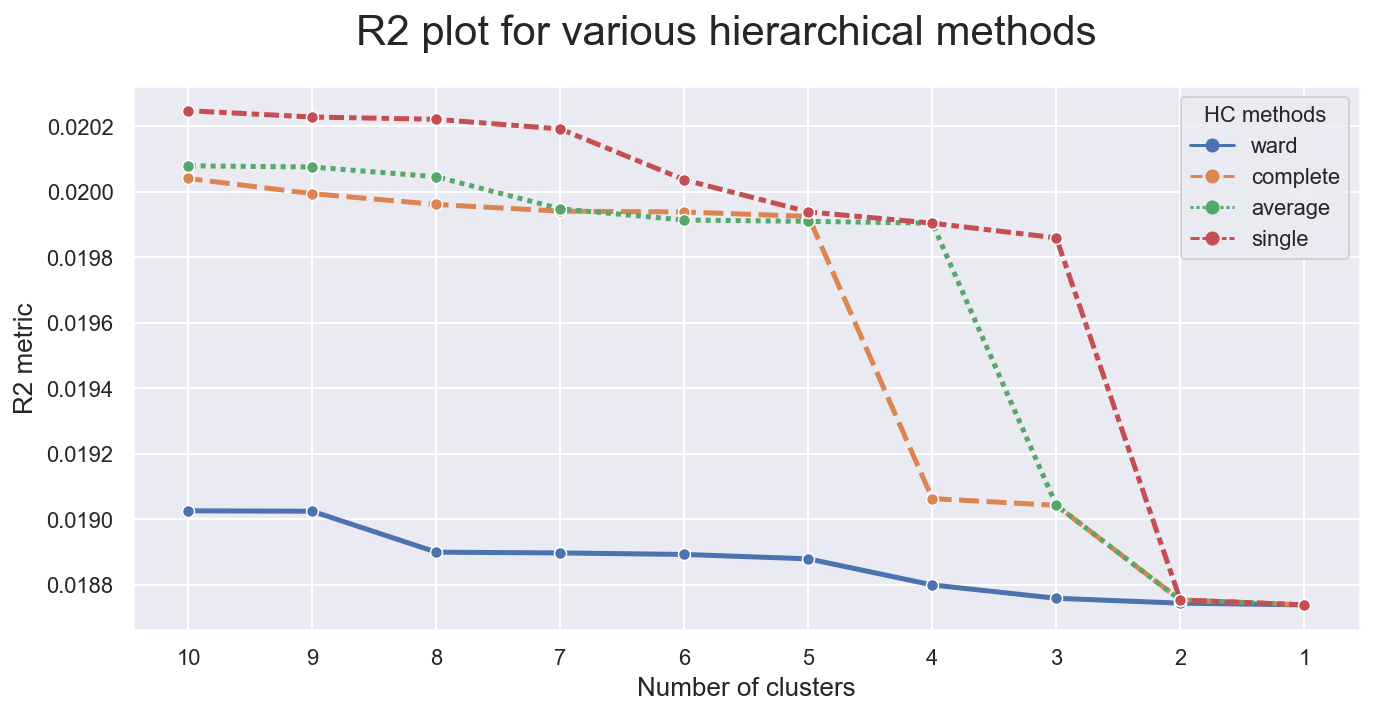

In [248]:
# Prepare input
hc_methods = ["ward", "complete", "average", "single"]
# Call function defined above to obtain the R2 statistic for each hc_method
max_nclus = 10
r2_hc_methods = np.vstack(
    [
        get_r2_hc(df_preprocessed=df_preprocessed[metric_features], link_method=link, max_nclus=max_nclus) 
        for link in hc_methods
    ]
).T
r2_hc_methods = pd.DataFrame(r2_hc_methods, index=range(1, max_nclus + 1), columns=hc_methods)

sns.set()
# Plot data
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
fig.suptitle("R2 plot for various hierarchical methods", fontsize=21)
plt.gca().invert_xaxis()  # invert x axis
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

plt.show()

# Defining the number of clusters:

In [79]:
# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, affinity=distance, distance_threshold=0, n_clusters=None)
hclust.fit_predict(df_preprocessed[metric_features])

array([6348, 6049, 8991, ...,    1,    2,    0], dtype=int64)

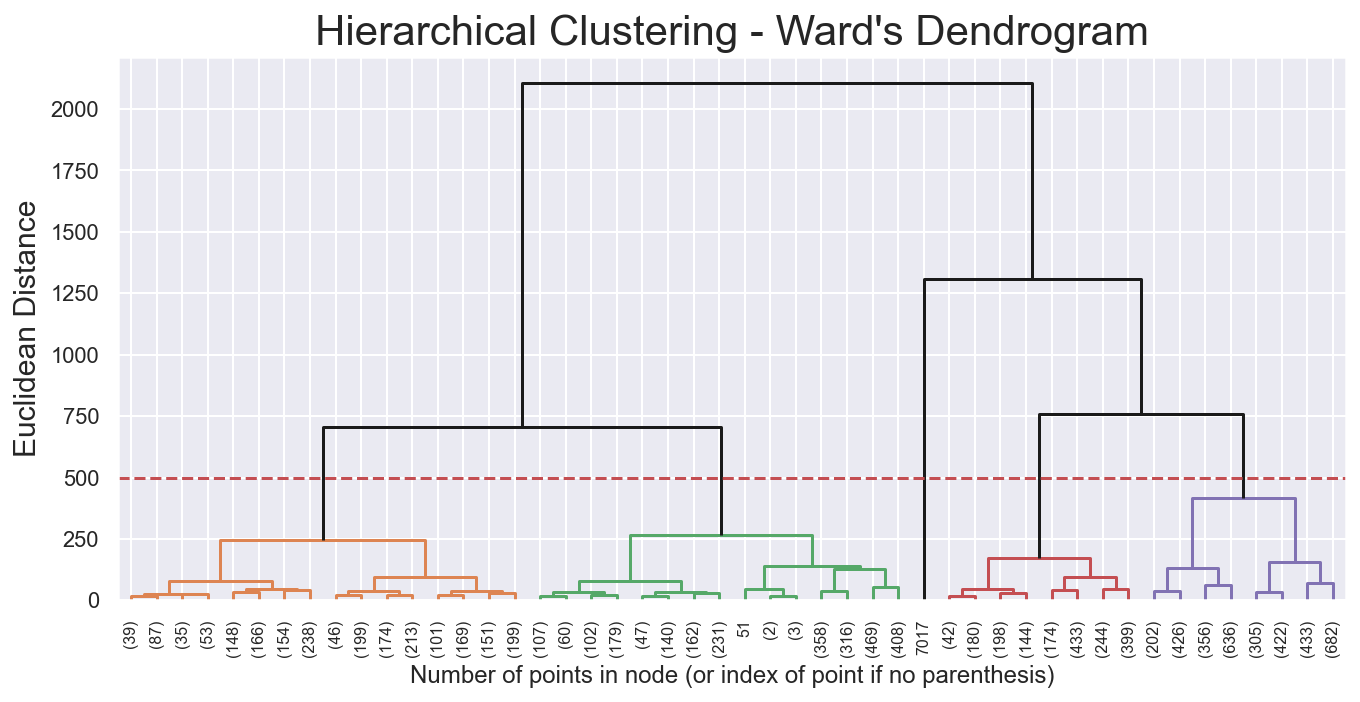

In [249]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 500
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=15)
plt.show()

# Final Hierarchical clustering solution

In [81]:
# 4 cluster solution
linkage = 'ward'
distance = 'euclidean'
hc4lust = AgglomerativeClustering(linkage=linkage, affinity=distance, n_clusters=5)
hc4_labels = hc4lust.fit_predict(df_preprocessed[metric_features])

In [82]:
# Characterizing the 4 clusters
df_concat = pd.concat((df_preprocessed, pd.Series(hc4_labels, name='labels')), axis=1)
df_concat.groupby('labels').mean()

Salary  Children       CMV    Claims     Motor  Household    Health  \
labels                                                                          
0.0     0.016345 -0.003046  0.010391 -0.010438  0.006755  -0.001412 -0.016124   
1.0    -0.027070  0.028282 -0.033353  0.046709  0.002243   0.001630  0.008457   
2.0    -1.085585  0.641444  0.178326 -0.186343  0.058331  -0.269329  0.569386   
3.0    -0.007602 -0.029327  0.013106 -0.010579 -0.035749   0.011258  0.018596   
4.0     0.021240 -0.016179  0.002879 -0.021018  0.005833  -0.001568  0.005186   

            Life  Work Compensation        age  x0_1 - Basic  \
labels                                                         
0.0     0.000319           0.009312  53.585787      0.105858   
1.0    -0.029972          -0.010732  53.290514      0.116996   
2.0     0.016861          -0.421881  46.000000      0.000000   
3.0     0.060796           0.021246  53.226659      0.116985   
4.0    -0.010381          -0.005987  53.800759      0.112903   

        x0_2 - High School  x0_3 - BSc/MSc  x0_4 - PhD       PC0       PC1  \
labels                                                                       
0.0               0.338388        0.488255    0.067499 -0.007887 -0.015381   
1.0               0.336364        0.475494    0.071146 -0.013323  0.054248   
2.0               1.000000        0.000000    0.000000 -0.082536 -0.233316   
3.0               0.352081        0.464004    0.066929  0.070748 -0.015843   
4.0               0.339658        0.472960    0.074478 -0.011004 -0.013700   

             PC2       PC3       PC4  
labels                                
0.0    -0.007430  0.020189  0.008415  
1.0     0.034733 -0.027710  0.002134  
2.0     0.844168 -1.104026 -0.277515  
3.0    -0.013043  0.010722 -0.014617  
4.0    -0.029765  0.000086  0.002563

# K-Means Clustering

In [83]:
df_preprocessed.columns

Index(['Salary', 'Children', 'CMV', 'Claims', 'Motor', 'Household', 'Health',
       'Life', 'Work Compensation', 'age', 'x0_1 - Basic',
       'x0_2 - High School', 'x0_3 - BSc/MSc', 'x0_4 - PhD', 'PC0', 'PC1',
       'PC2', 'PC3', 'PC4'],
      dtype='object')

In [84]:
kmclust = KMeans(n_clusters=5, init='random', n_init=1, random_state=None)
kmclust.fit(df_preprocessed[metric_features])
kmclust.predict(df_preprocessed[metric_features])

array([3, 2, 0, ..., 3, 3, 3])

In [85]:
kmclust.transform(df_preprocessed[metric_features])

array([[15.75989949, 39.51487926, 10.04492606,  3.31158815, 27.58585168],
       [29.28531104, 52.71933001,  4.73105009, 16.86360061, 40.87409745],
       [ 5.24353592, 27.54957741, 21.79947145,  9.51751195, 15.78826462],
       ...,
       [ 9.82333542, 33.53887207, 16.06392653,  3.50810306, 21.61721093],
       [11.19300279, 34.5497882 , 14.68783986,  3.00156091, 22.67350956],
       [14.76411133, 38.51959617, 11.24757147,  2.76891689, 26.59642447]])

In [86]:
kmclust = KMeans(n_clusters=5, init='k-means++', n_init=15, random_state= 42)
kmclust.fit(df_preprocessed[metric_features])

KMeans(n_clusters=5, n_init=15, random_state=42)

In [87]:
kmclust.predict(df_preprocessed[metric_features])

array([0, 4, 0, ..., 0, 0, 0])

## Defining the number of Clusters:

In [91]:
range_clusters = range(1, 15)

In [92]:
inertia = []
for n_clus in range_clusters:
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state= 42)
    kmclust.fit(df_preprocessed[metric_features])
    inertia.append(kmclust.inertia_)   

In [93]:
pd.Series(inertia, index = range_clusters)

1     3.911850e+06
2     1.689650e+06
3     8.338924e+05
4     4.154621e+05
5     2.651032e+05
6     1.925941e+05
7     1.540200e+05
8     1.308885e+05
9     1.149428e+05
10    1.034003e+05
11    9.439426e+04
12    8.678954e+04
13    8.011925e+04
14    7.603363e+04
dtype: float64

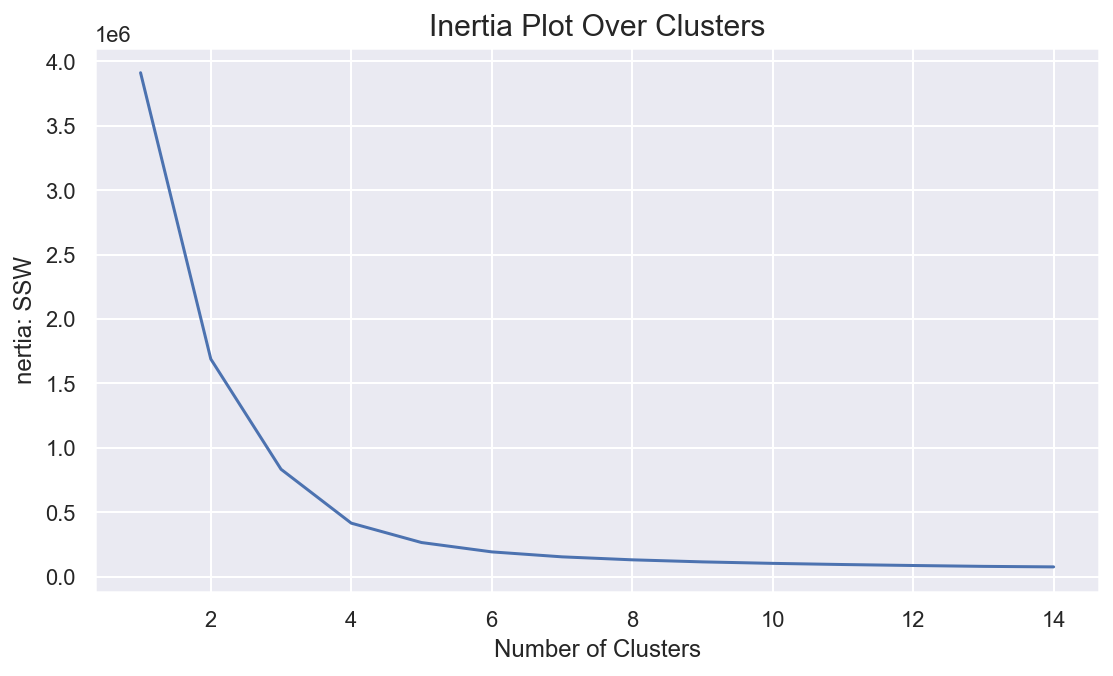

In [94]:
plt.figure(figsize=(9,5))
plt.plot(pd.Series(inertia, index = range_clusters))
plt.ylabel('nertia: SSW')
plt.xlabel('Number of Clusters')
plt.title('Inertia Plot Over Clusters', size = 15)
plt.show()

For n_clusters = 2, the average silhouette_score is : 0.593256254462704
For n_clusters = 3, the average silhouette_score is : 0.5960440899103848
For n_clusters = 4, the average silhouette_score is : 0.5349133257129735
For n_clusters = 5, the average silhouette_score is : 0.49300805206370113
For n_clusters = 6, the average silhouette_score is : 0.46302604351575116
For n_clusters = 7, the average silhouette_score is : 0.43175945098774726
For n_clusters = 8, the average silhouette_score is : 0.3988661412529029
For n_clusters = 9, the average silhouette_score is : 0.3743274173807323
For n_clusters = 10, the average silhouette_score is : 0.3577755507995409
For n_clusters = 11, the average silhouette_score is : 0.35784485168000235
For n_clusters = 12, the average silhouette_score is : 0.3335663869818054
For n_clusters = 13, the average silhouette_score is : 0.3174671353485664
For n_clusters = 14, the average silhouette_score is : 0.2946029400266044


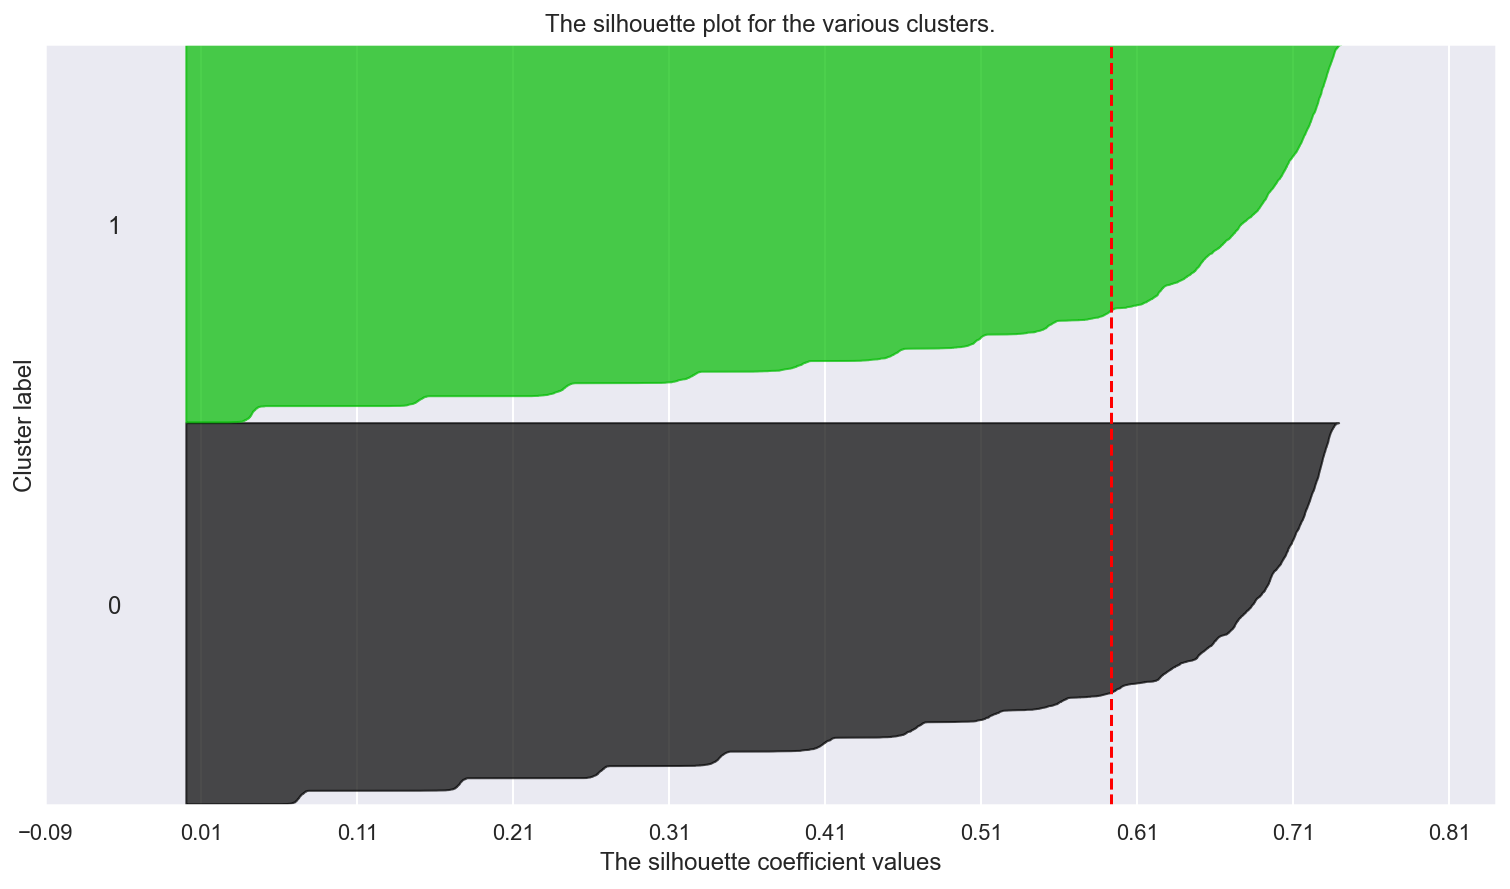

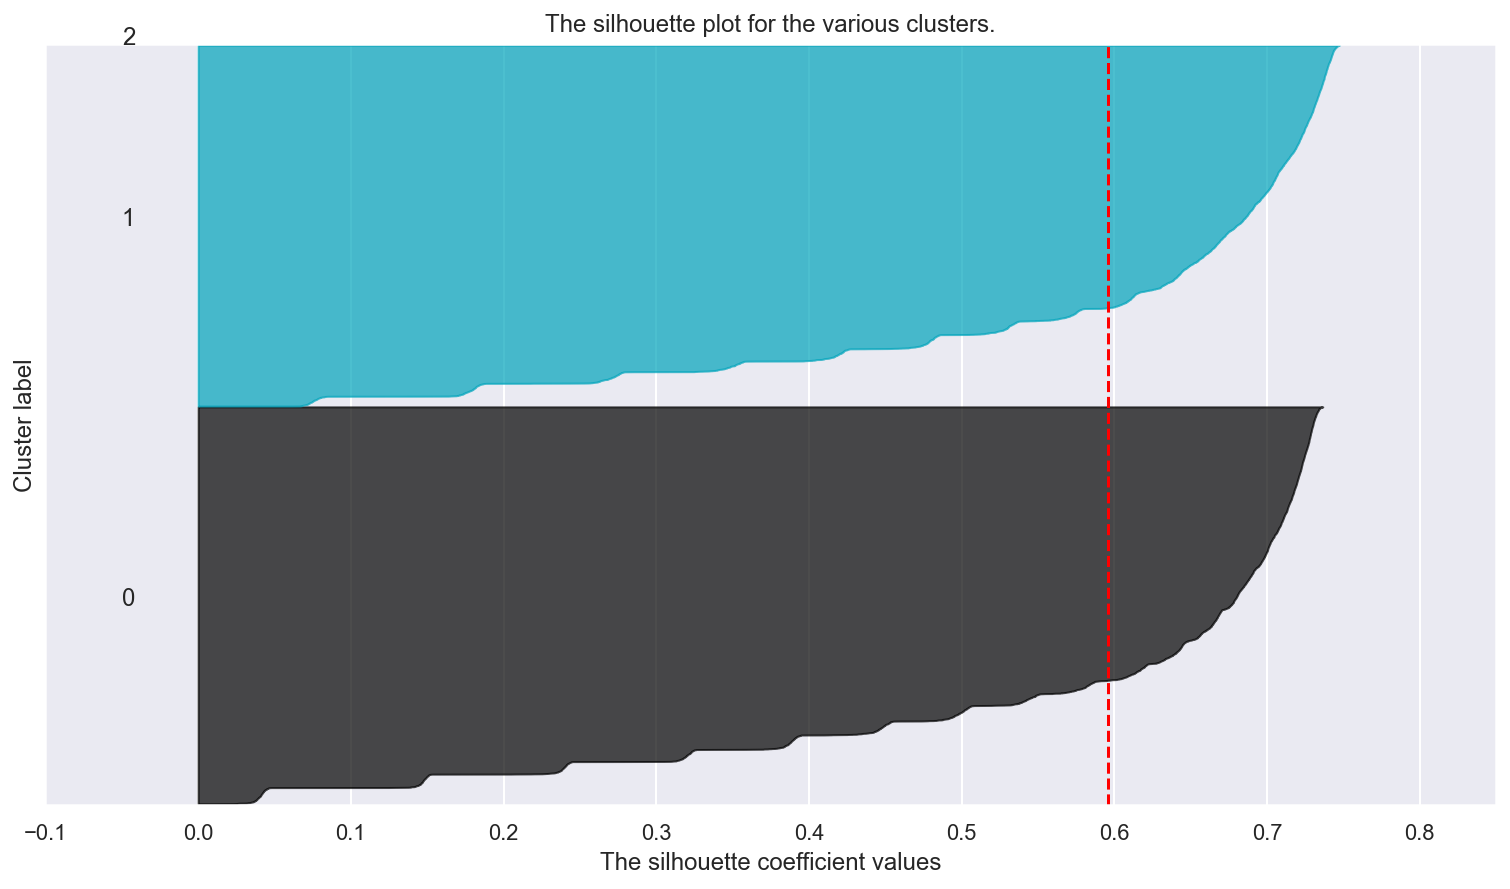

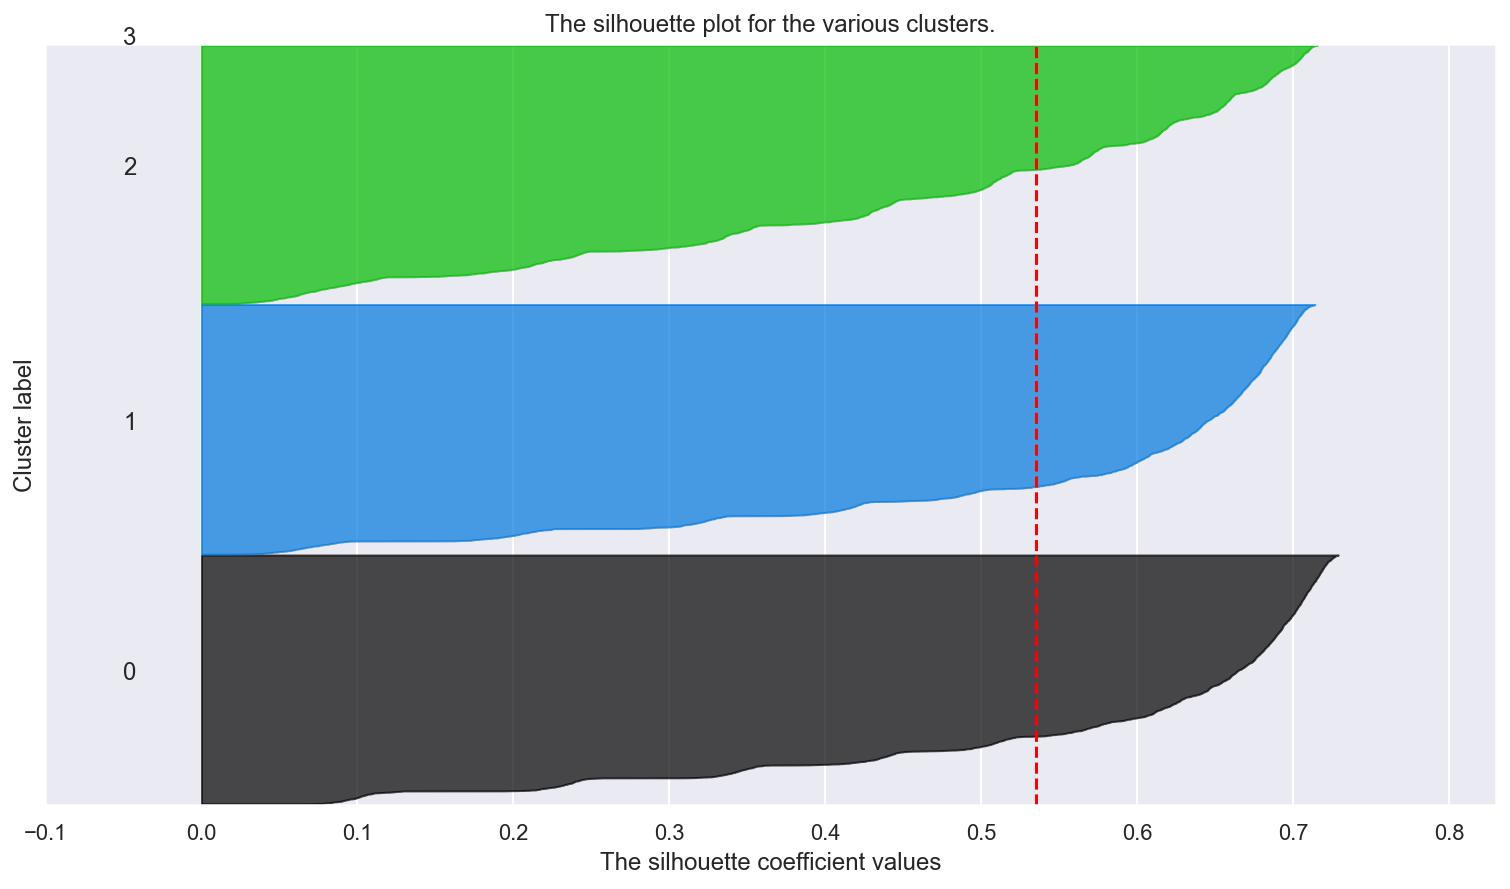

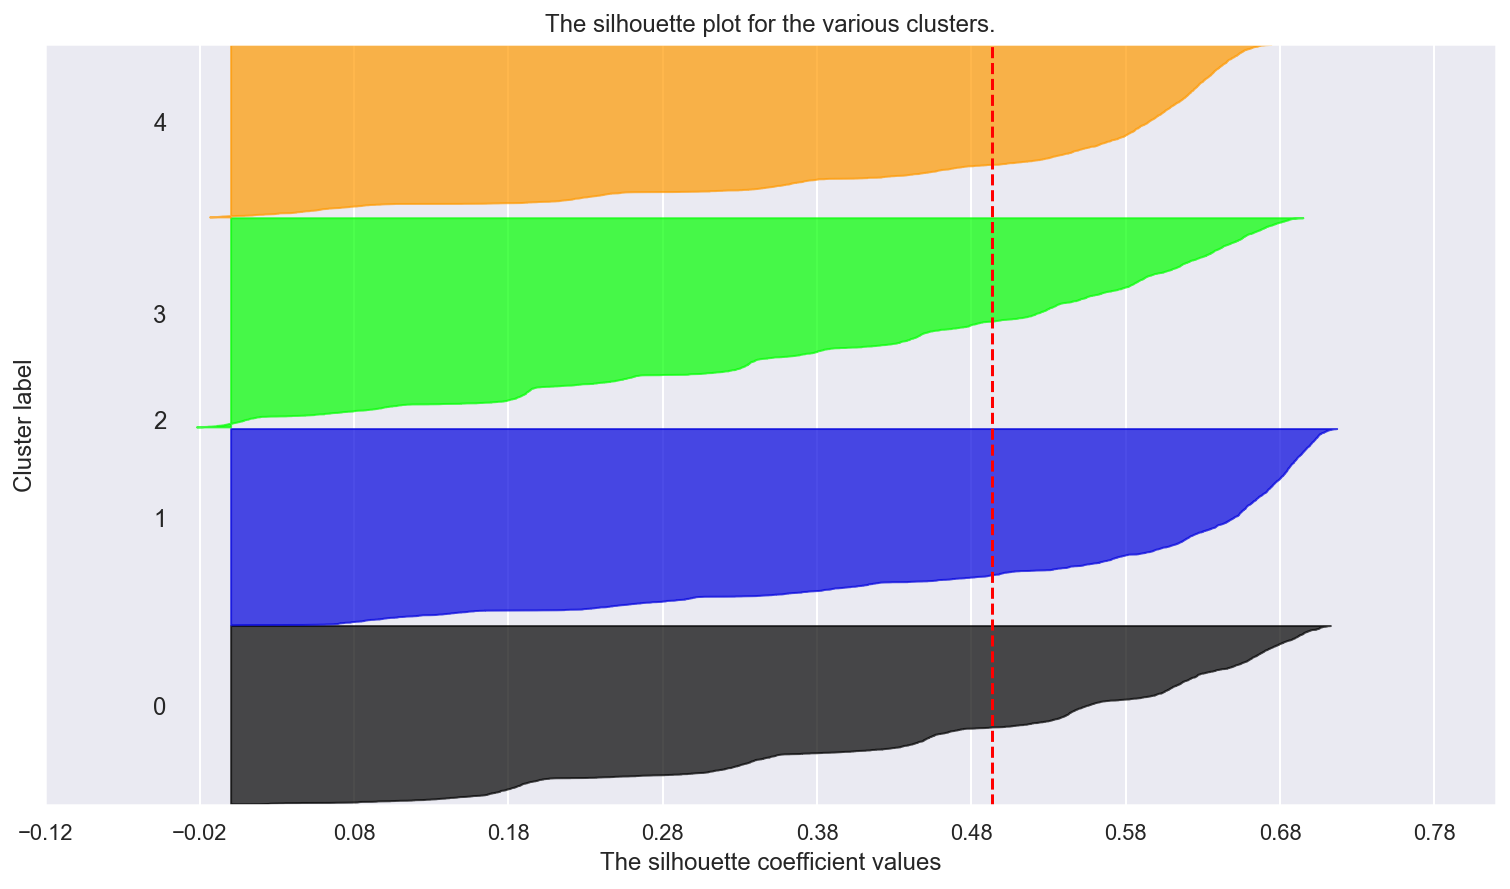

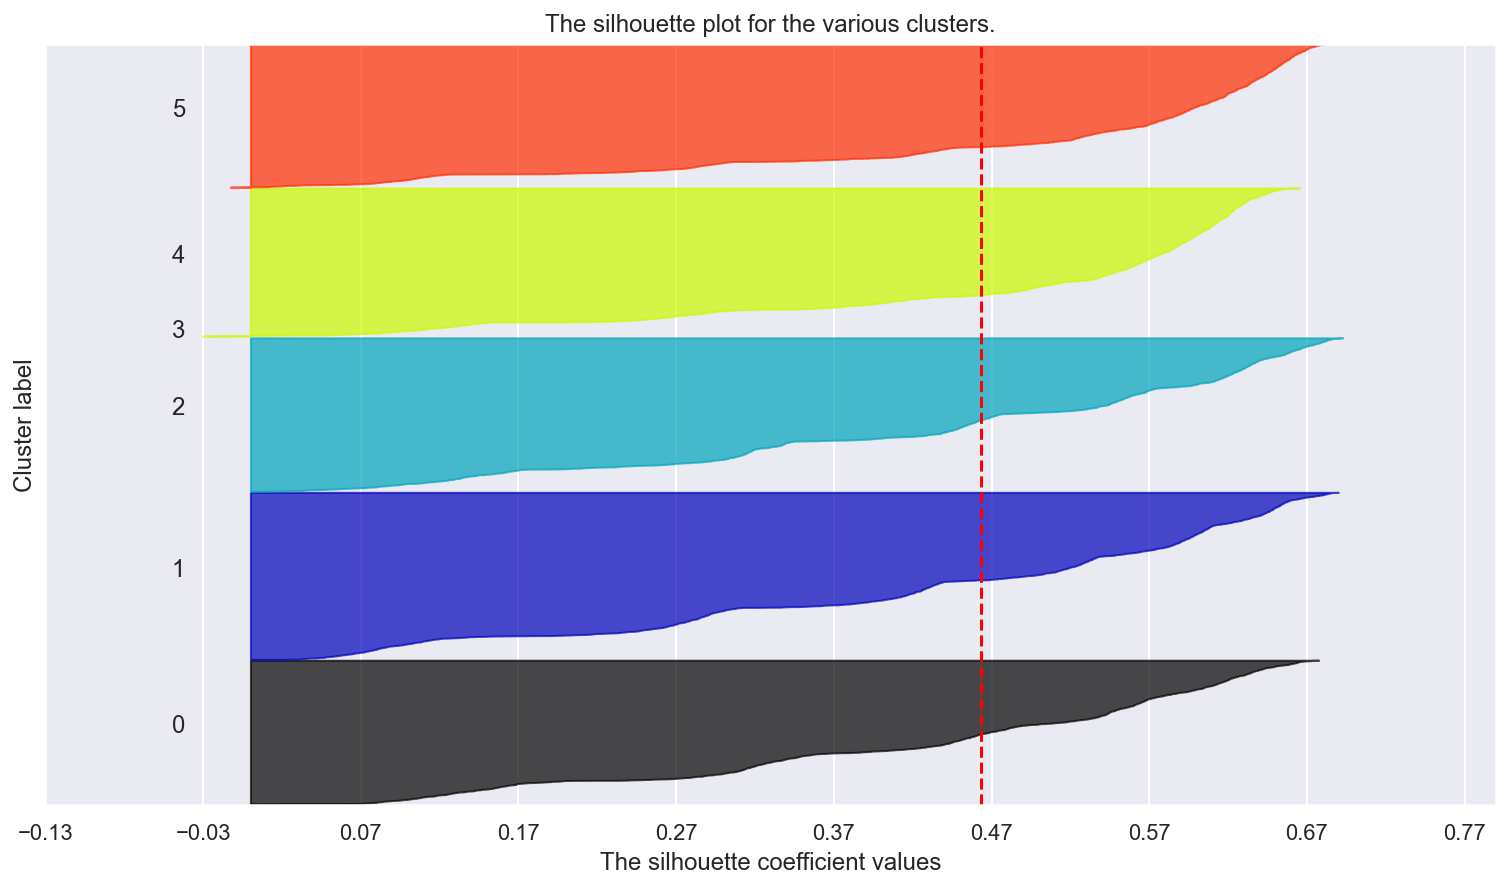

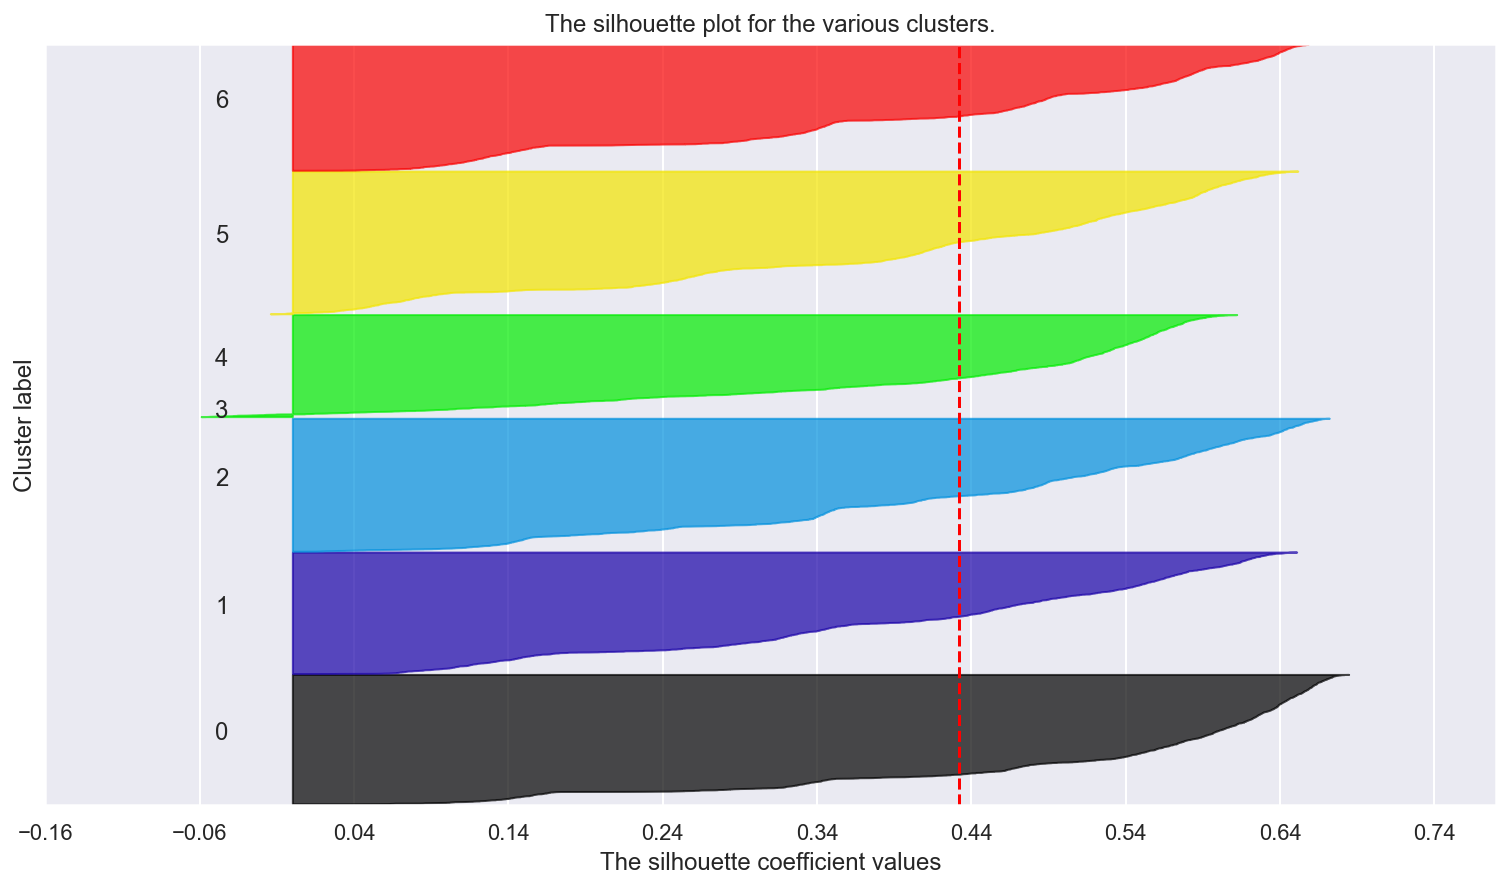

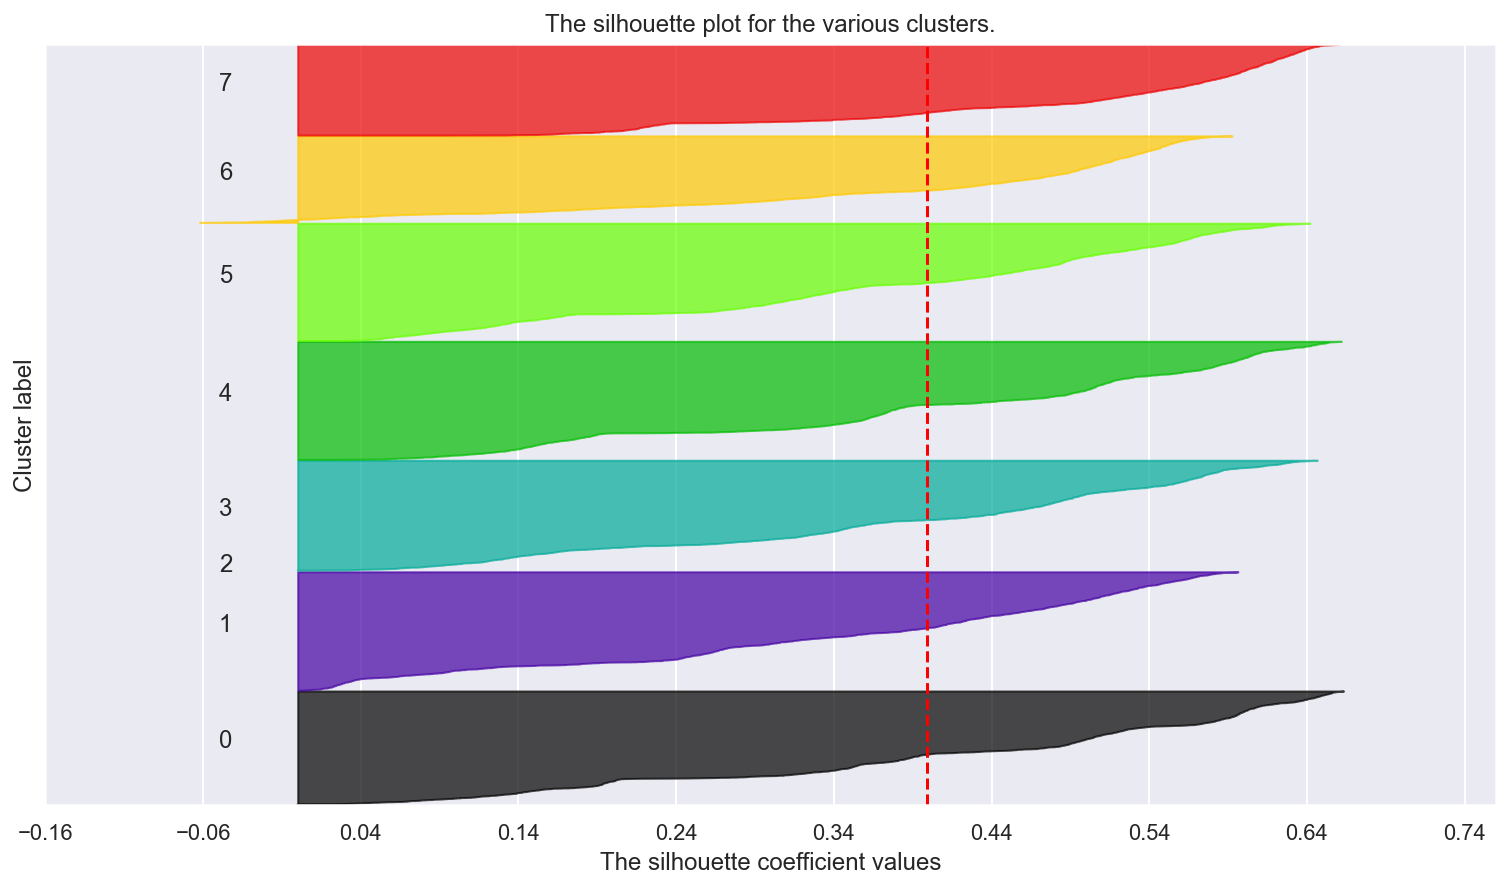

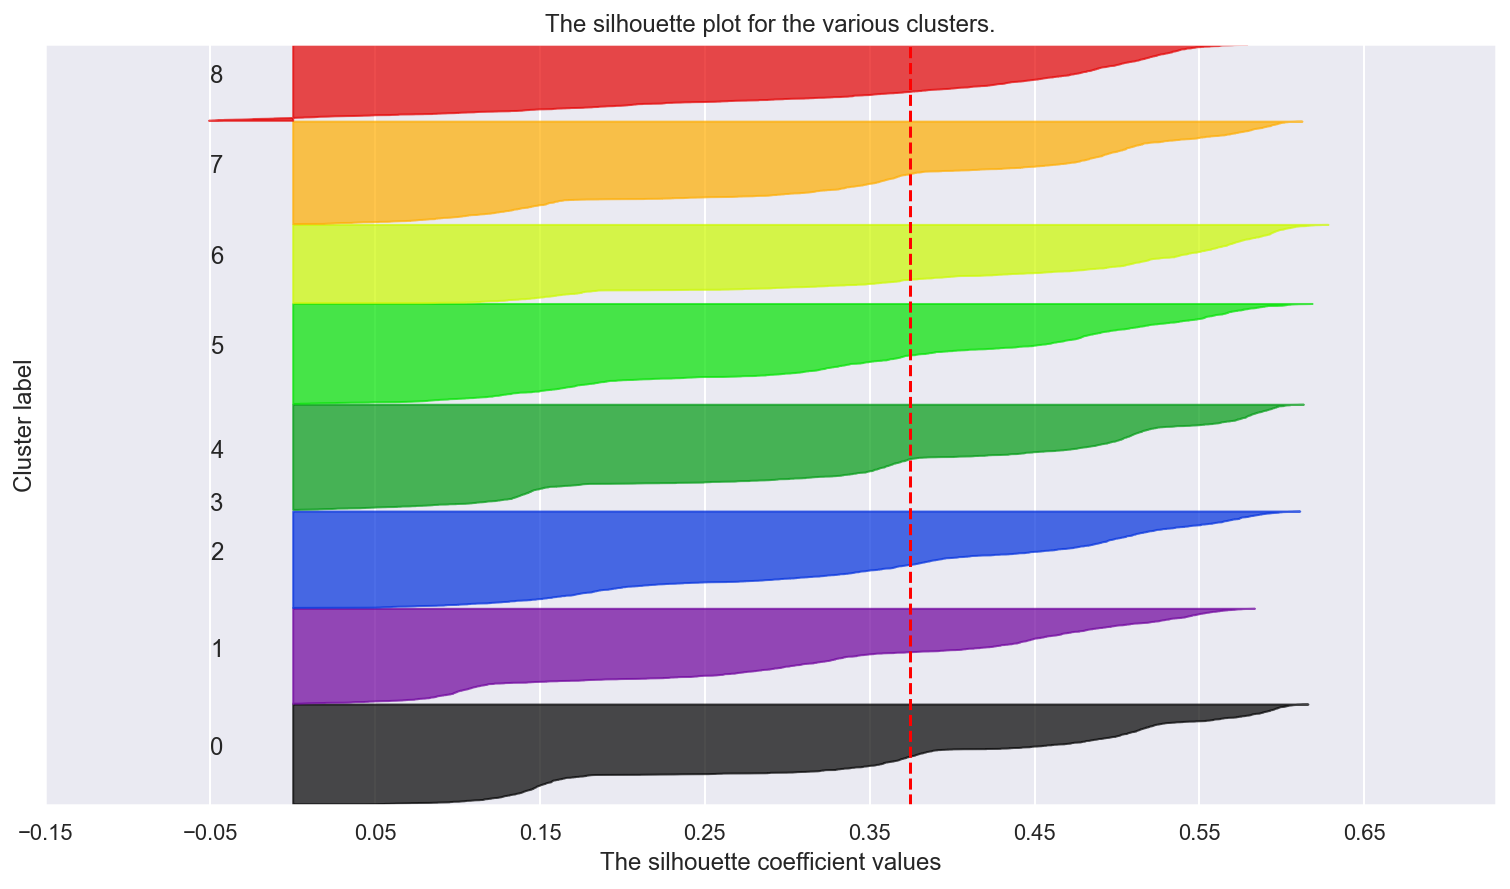

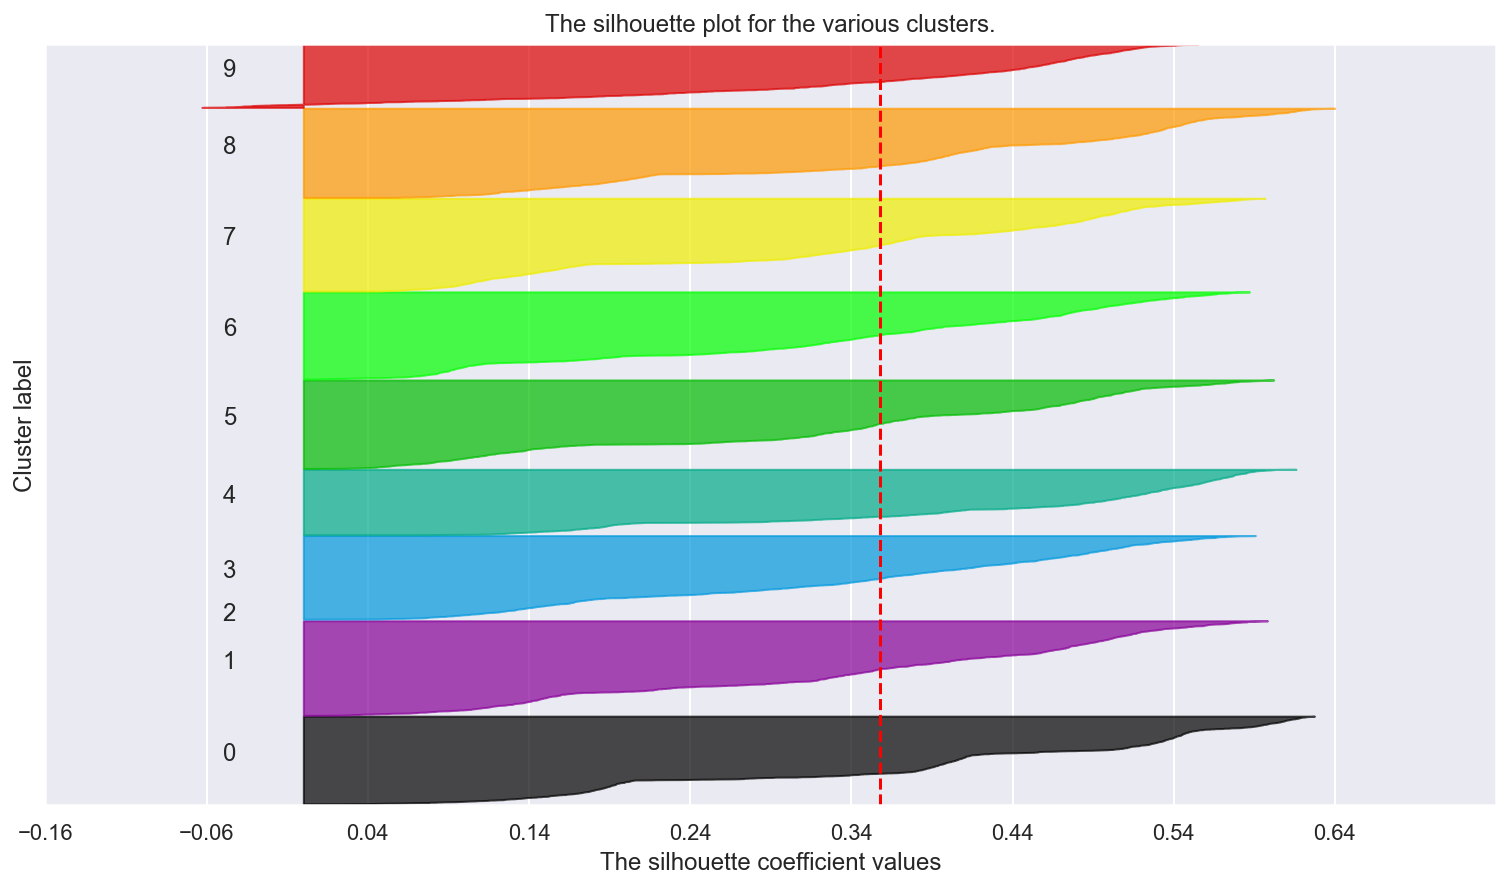

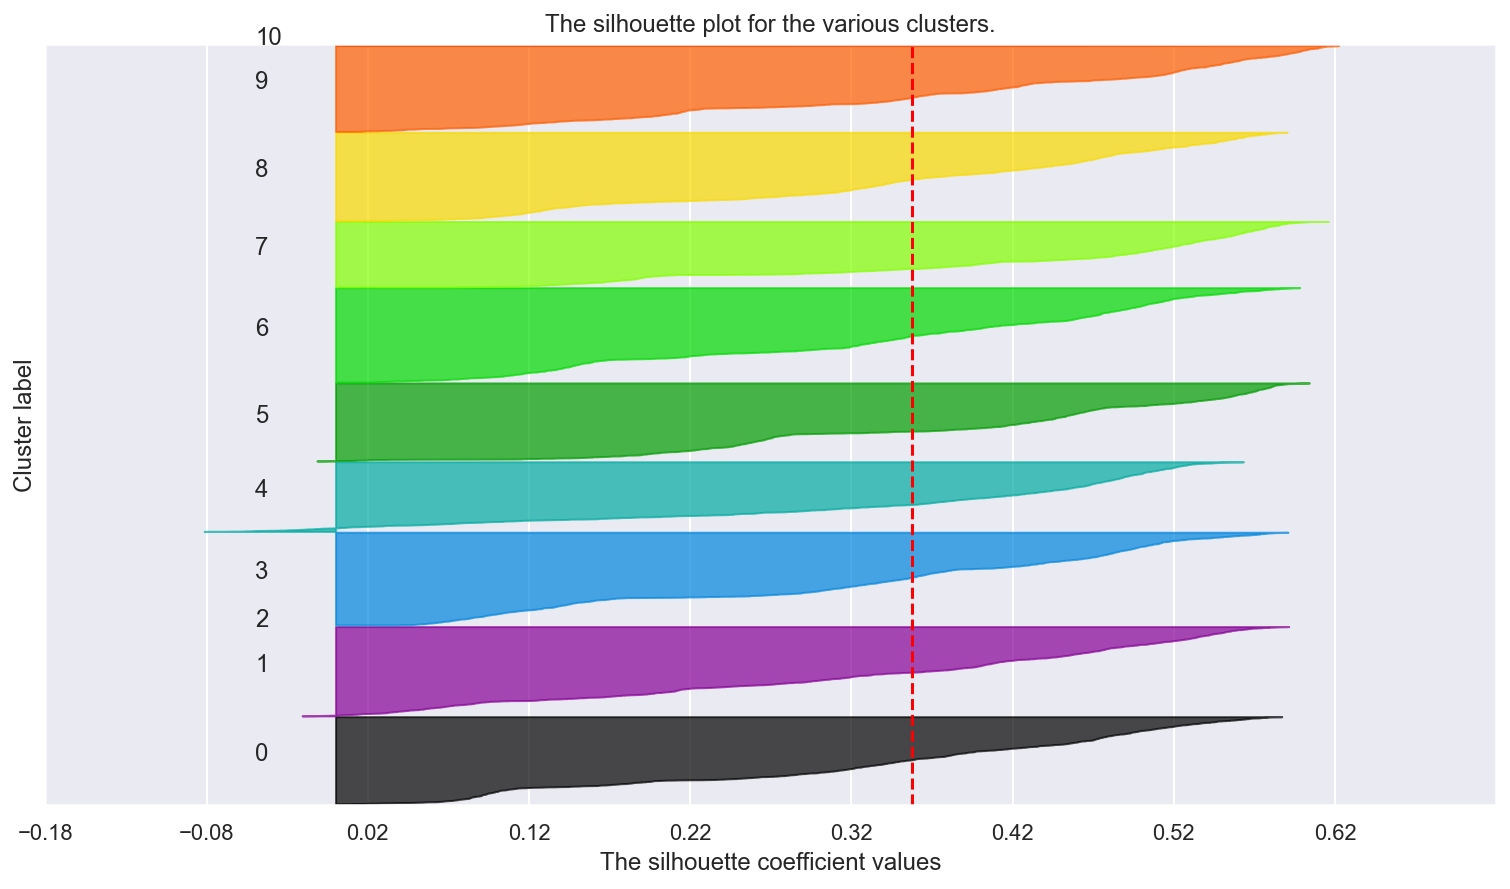

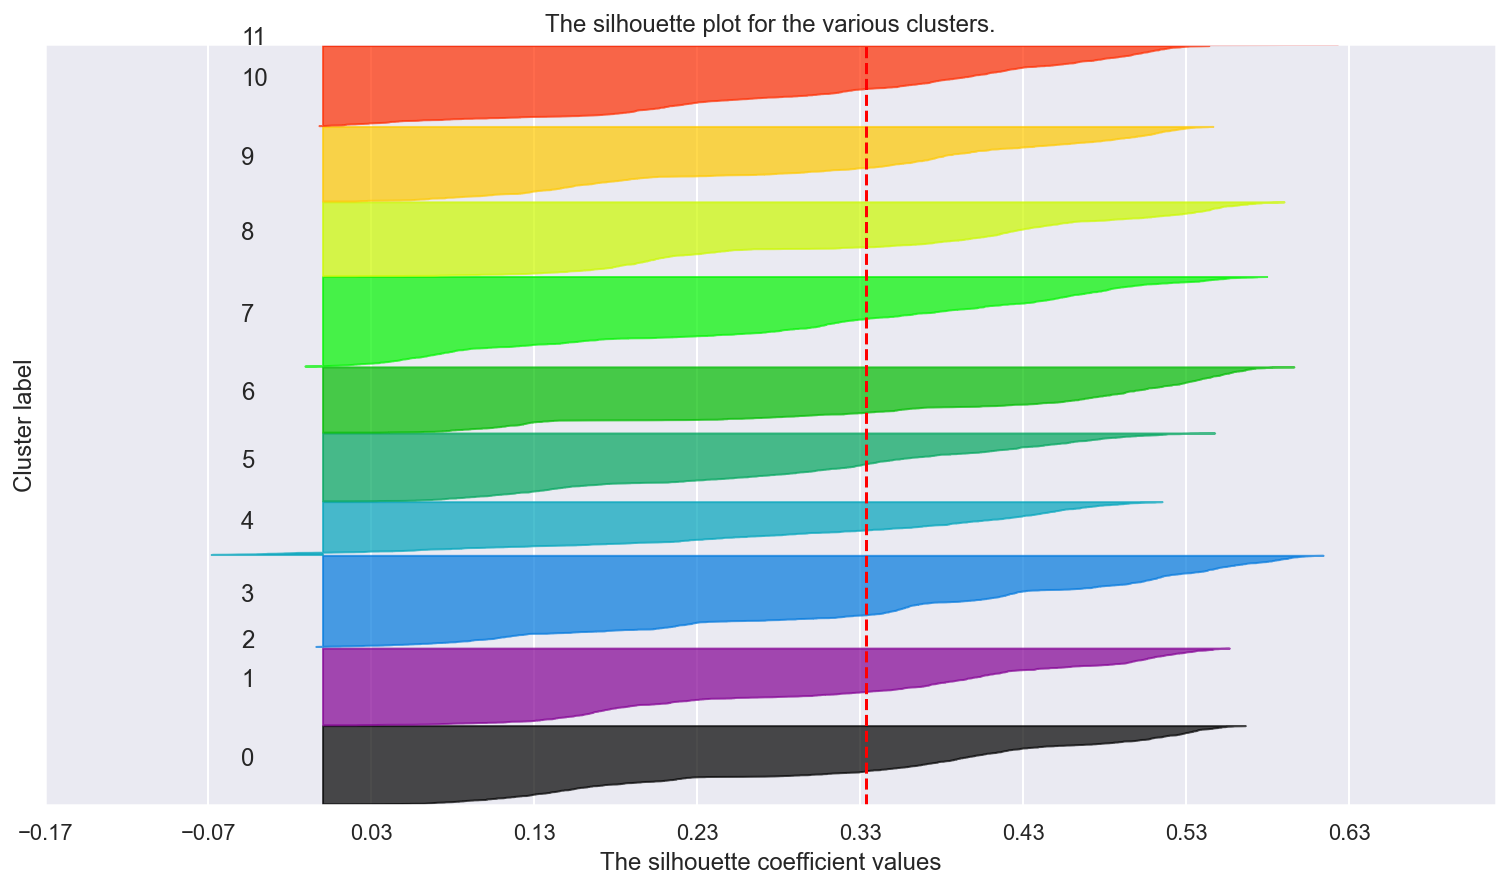

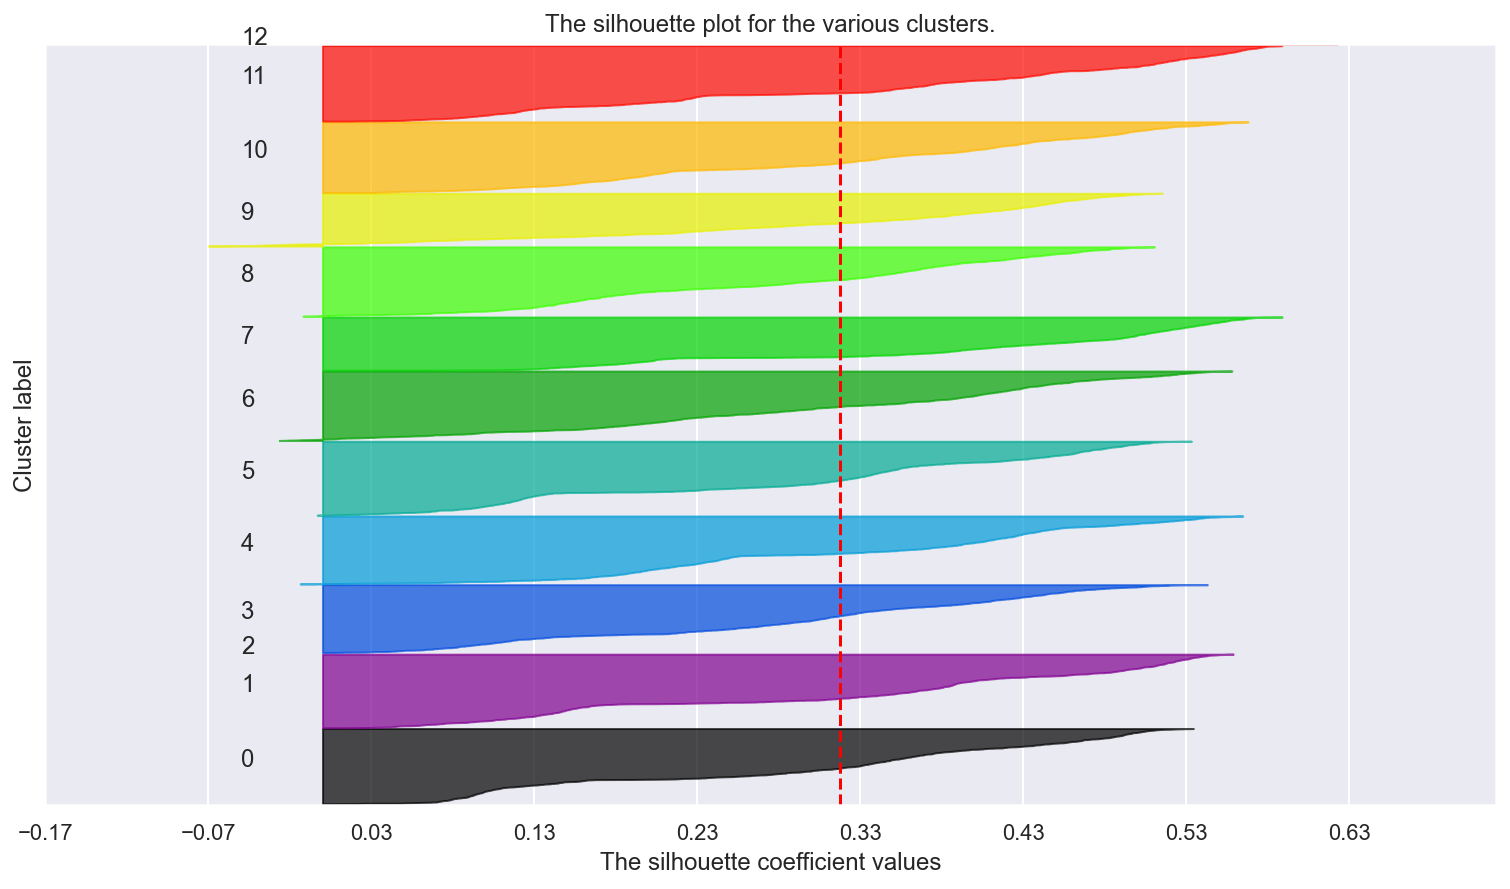

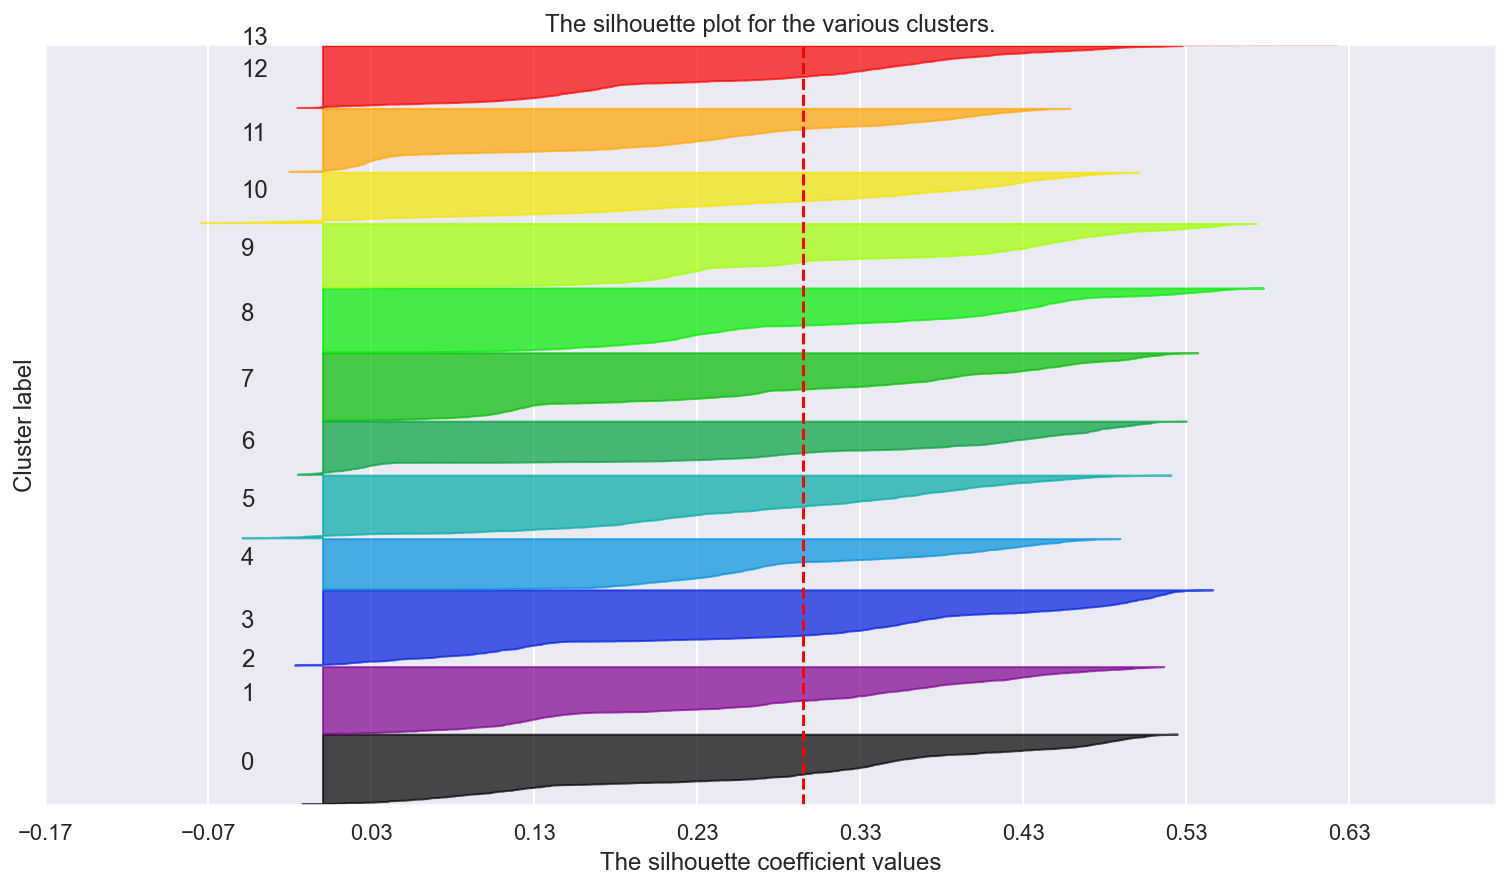

In [95]:
# Storing average silhouette metric
avg_silhouette = []
for nclus in range_clusters:
     # Skip nclus == 1
    if nclus == 1:
        continue
    
    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
    cluster_labels = kmclust.fit_predict(df_preprocessed[metric_features])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(df_preprocessed[metric_features], cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_preprocessed[metric_features], cluster_labels)

    y_lower = 10
    for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Get y_upper to demarcate silhouette y range size
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Filling the silhouette
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # The silhouette coefficient can range from -1, 1
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(df[metric_features]) + (nclus + 1) * 10])

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks(np.arange(xmin, xmax, 0.1))

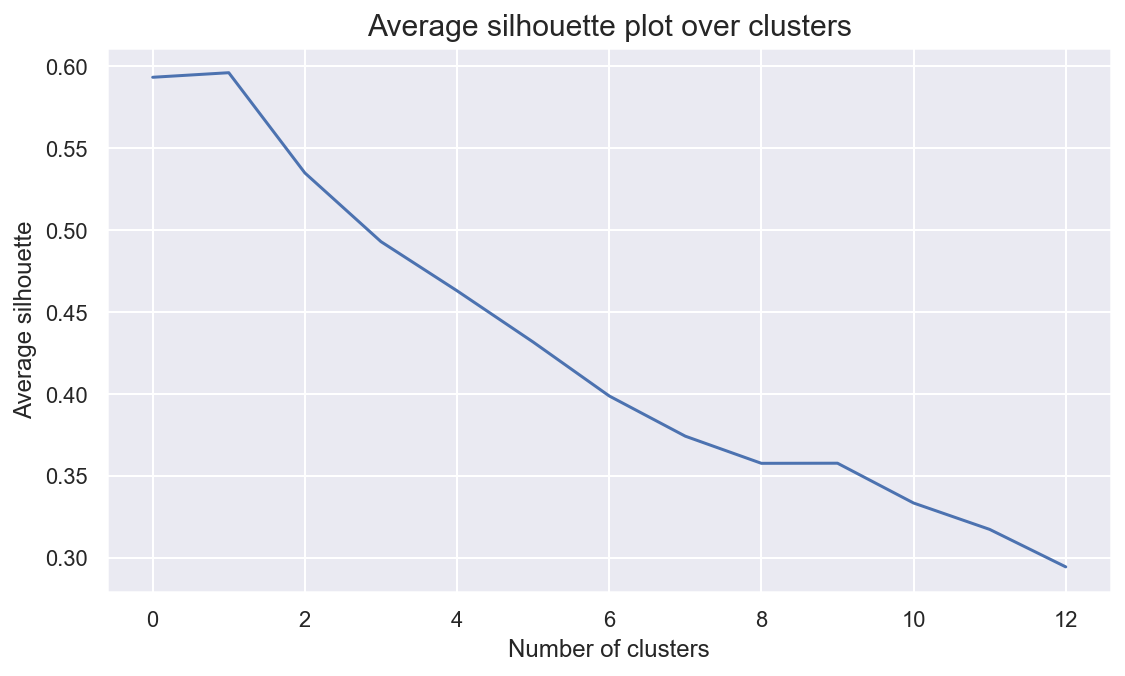

In [96]:
# The average silhouette plot
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(avg_silhouette)
plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

## Final KMeans clustering solution

In [97]:
# final cluster solution
number_clusters = 4
kmclust = KMeans(n_clusters= number_clusters, init='k-means++', n_init=15, random_state=1)
km_labels = kmclust.fit_predict(df_preprocessed[metric_features])
km_labels

array([1, 1, 2, ..., 2, 2, 1])

In [98]:
# Characterizing the final clusters
df_concat = pd.concat((df_preprocessed, pd.Series(km_labels, name='labels')), axis=1)
df_concat.groupby('labels').mean()

Salary  Children       CMV    Claims     Motor  Household    Health  \
labels                                                                          
0.0     0.008629 -0.032715  0.015598 -0.014961 -0.026600   0.003579  0.016205   
1.0     0.006018 -0.012202 -0.003144 -0.006181 -0.001042  -0.003793  0.007870   
2.0    -0.008809  0.035816 -0.017992  0.026352  0.019768   0.005036 -0.019860   
3.0    -1.085585  0.641444  0.178326 -0.186343  0.058331  -0.269329  0.569386   

            Life  Work Compensation        age  x0_1 - Basic  \
labels                                                         
0.0     0.031724           0.027360  53.452255      0.111042   
1.0    -0.009201          -0.003373  53.475039      0.113488   
2.0    -0.018227          -0.014306  53.542078      0.112309   
3.0     0.016861          -0.421881  46.000000      0.000000   

        x0_2 - High School  x0_3 - BSc/MSc  x0_4 - PhD       PC0       PC1  \
labels                                                                       
0.0               0.342768        0.478694    0.067496  0.049661 -0.018731   
1.0               0.339535        0.471938    0.075039 -0.003207  0.000378   
2.0               0.339623        0.480982    0.067086 -0.032032  0.026198   
3.0               1.000000        0.000000    0.000000 -0.082536 -0.233316   

             PC2       PC3       PC4  
labels                                
0.0    -0.028144  0.010289  0.007520  
1.0    -0.016523 -0.006377  0.003774  
2.0     0.036155  0.001355 -0.006959  
3.0     0.844168 -1.104026 -0.277515

# Self-organizing maps

In [111]:
np.random.seed(42)

sm = sompy.SOMFactory().build(
    df_preprocessed[metric_features].values, 
    mapsize=(10, 10), 
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=metric_features
)
sm.train(n_job=4, verbose='info', train_rough_len=100, train_finetune_len=100)

 Training...
 pca_linear_initialization took: 0.025000 seconds
 Rough training...
 radius_ini: 2.000000 , radius_final: 1.000000, trainlen: 100

 epoch: 1 ---> elapsed time:  0.071000, quantization error: 1.810782

 epoch: 2 ---> elapsed time:  0.074000, quantization error: 2.305128

 epoch: 3 ---> elapsed time:  0.076000, quantization error: 2.172789

 epoch: 4 ---> elapsed time:  0.077000, quantization error: 2.153816

 epoch: 5 ---> elapsed time:  0.071000, quantization error: 2.141992

 epoch: 6 ---> elapsed time:  0.071000, quantization error: 2.133470

 epoch: 7 ---> elapsed time:  0.081000, quantization error: 2.126258

 epoch: 8 ---> elapsed time:  0.072000, quantization error: 2.119955

 epoch: 9 ---> elapsed time:  0.077000, quantization error: 2.114100

 epoch: 10 ---> elapsed time:  0.077000, quantization error: 2.108573

 epoch: 11 ---> elapsed time:  0.074000, quantization error: 2.102212

 epoch: 12 ---> elapsed time:  0.075000, quantization error: 2.094270

 epoch: 13 -

C:\Users\foazu\anaconda3\lib\site-packages\sompy\visualization\umatrix.py:115: UserWarning: For hexagonal lattice, distance < sqrt(3) produces a null U-matrix.
  warn("For hexagonal lattice, distance < sqrt(3) produces a null U-matrix.")
C:\Users\foazu\anaconda3\lib\site-packages\sompy\visualization\umatrix.py:45: RuntimeWarning: invalid value encountered in double_scalars
  Umatrix[i] = np.sum(neighborbor_dists) / (neighborbor_dists.shape[1] - 1)
C:\Users\foazu\anaconda3\lib\site-packages\matplotlib\contour.py:1430: UserWarning: Warning: converting a masked element to nan.
  x, y, z = self._contour_args(args, kwargs)
C:\Users\foazu\anaconda3\lib\site-packages\matplotlib\contour.py:1431: UserWarning: Warning: converting a masked element to nan.
  
C:\Users\foazu\anaconda3\lib\site-packages\sompy\visualization\umatrix.py:53: UserWarning: No contour levels were found within the data range.
  ax.contour(X, Y, umat, np.linspace(mn, md, 15),


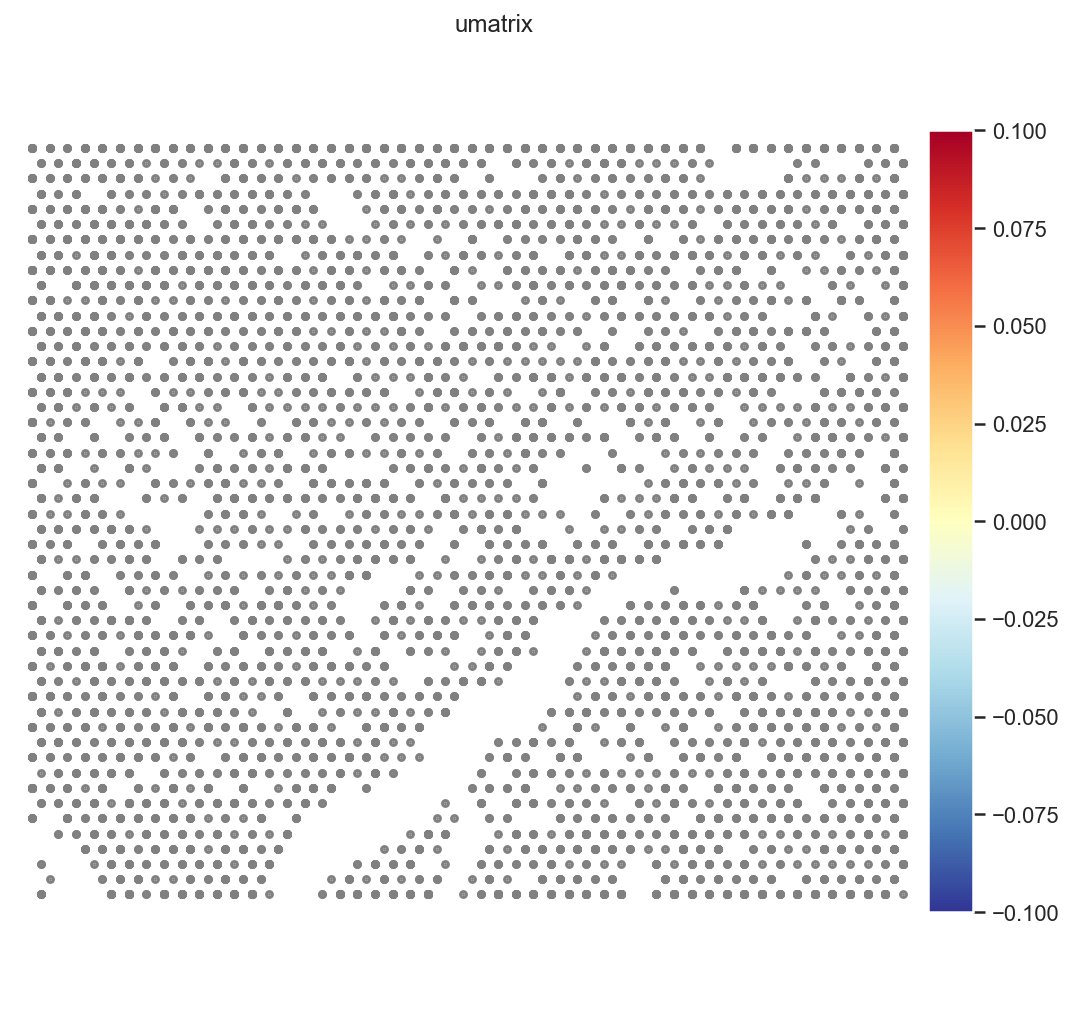

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [250]:
# Here you have U-matrix
u = sompy.umatrix.UMatrixView(12, 12, 'umatrix', show_axis=True, text_size=8, show_text=True)

UMAT = u.show(
    sm, 
    distance=1, 
    row_normalized=False, 
    show_data=True, 
    contour=True, # Visualize isomorphic curves
    blob=False
)

UMAT[1]  # U-matrix values - no colorscale so we have to rely on the values :(

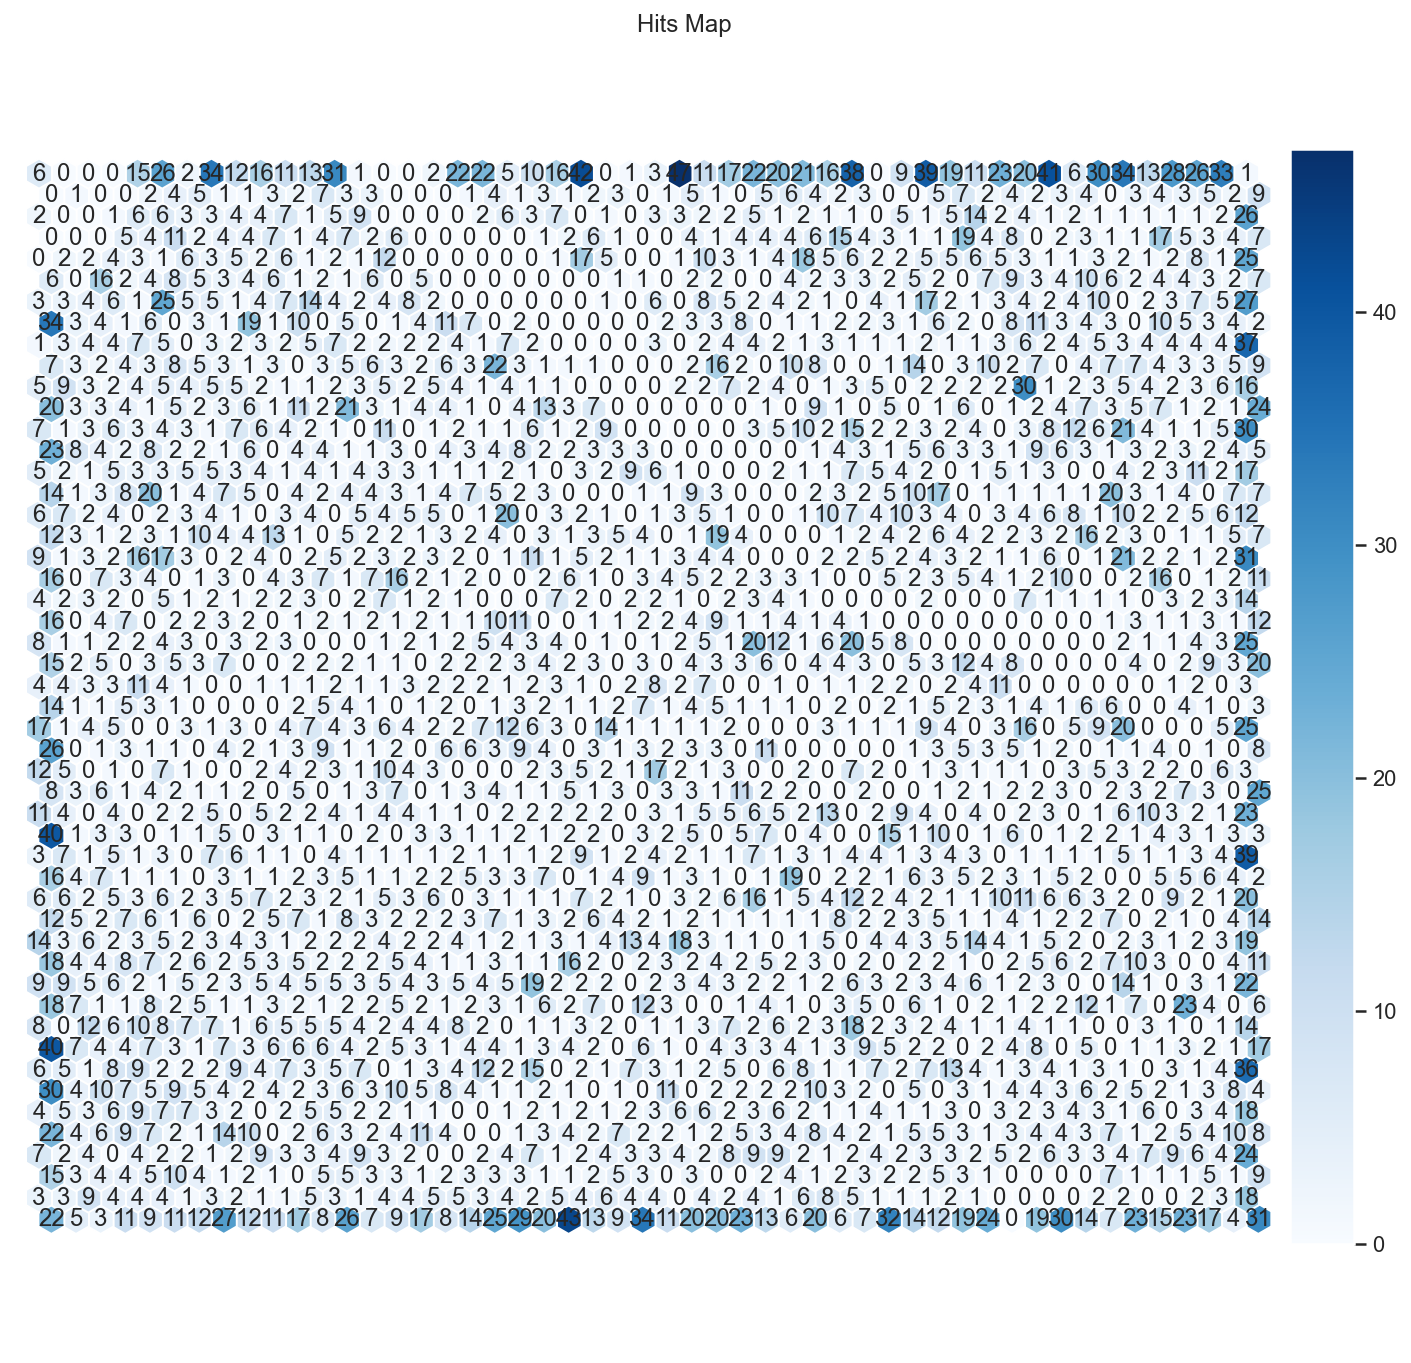

In [202]:
vhts  = BmuHitsView(12,12,"Hits Map")
vhts.show(sm, anotate=True, onlyzeros=False, labelsize=12, cmap="Blues")
plt.show()

### Clustering with SOMs: K-means SOM vs Emergent SOM

In [203]:
np.random.seed(42)

# Notice that the SOM did not converge - We're under a time constraint for this class
sm = sompy.SOMFactory().build(
    df_preprocessed[metric_features].values, 
    mapsize=(50, 50), 
    initialization='random',
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=metric_features
)
sm.train(n_job=-1, verbose='info', train_rough_len=100, train_finetune_len=100)

 Training...
 random_initialization took: 0.000000 seconds
 Rough training...
 radius_ini: 17.000000 , radius_final: 2.833333, trainlen: 100

 epoch: 1 ---> elapsed time:  1.024000, quantization error: 8.319874

 epoch: 2 ---> elapsed time:  0.993000, quantization error: 2.787754

 epoch: 3 ---> elapsed time:  0.946000, quantization error: 2.755909

 epoch: 4 ---> elapsed time:  0.995000, quantization error: 2.746195

 epoch: 5 ---> elapsed time:  0.974000, quantization error: 2.740568

 epoch: 6 ---> elapsed time:  0.973000, quantization error: 2.734427

 epoch: 7 ---> elapsed time:  0.925000, quantization error: 2.732053

 epoch: 8 ---> elapsed time:  0.918000, quantization error: 2.730677

 epoch: 9 ---> elapsed time:  0.915000, quantization error: 2.729355

 epoch: 10 ---> elapsed time:  0.917000, quantization error: 2.728018

 epoch: 11 ---> elapsed time:  0.948000, quantization error: 2.726662

 epoch: 12 ---> elapsed time:  0.935000, quantization error: 2.725278

 epoch: 13 --->

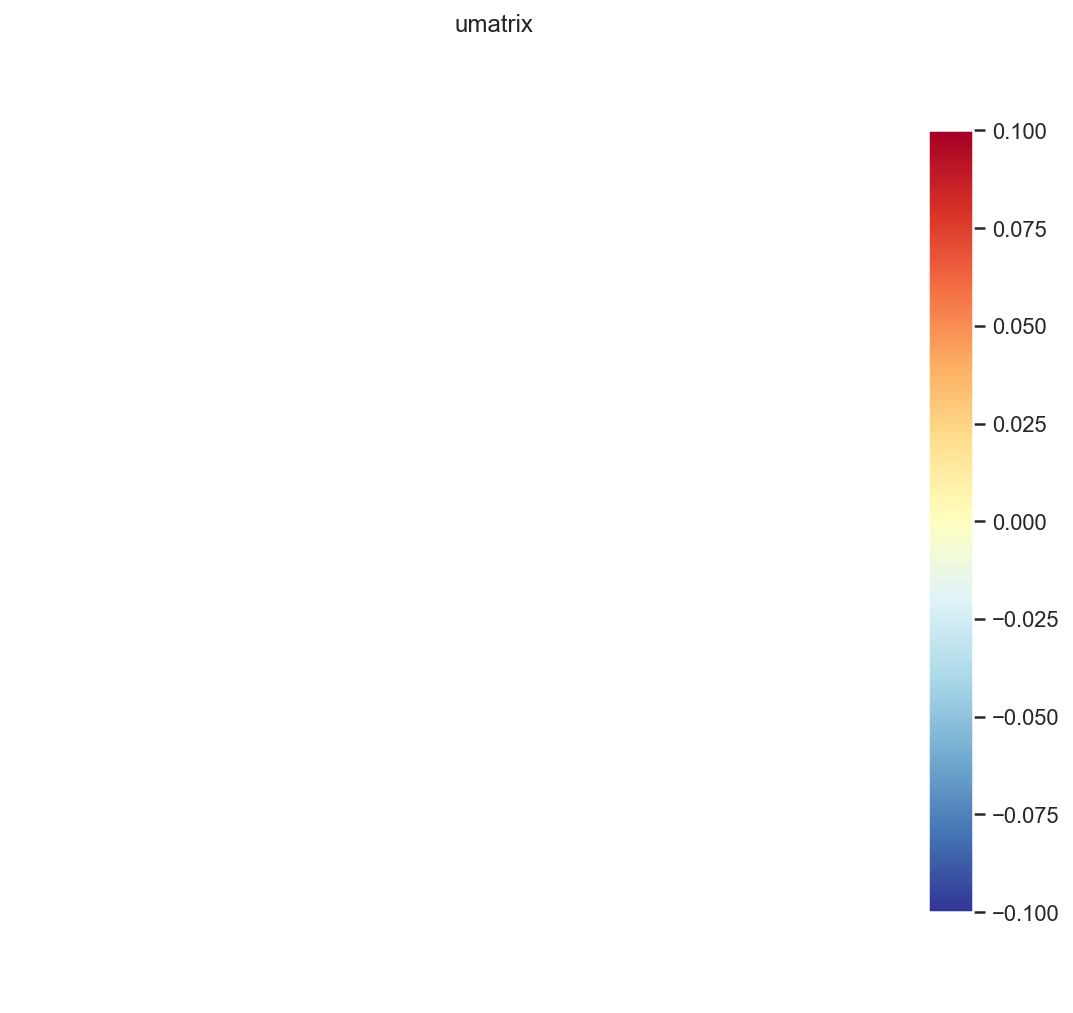

In [208]:
# U-matrix of the 50x50 grid
u = sompy.umatrix.UMatrixView(12, 12, 'umatrix', show_axis=True, text_size=8, show_text=True)

UMAT = u.show(
    sm, 
    distance=1, 
    row_normalized=False, 
    show_data=False, 
    contour=True # Visualize isomorphic curves
)

#### K-Means on top of SOM units 

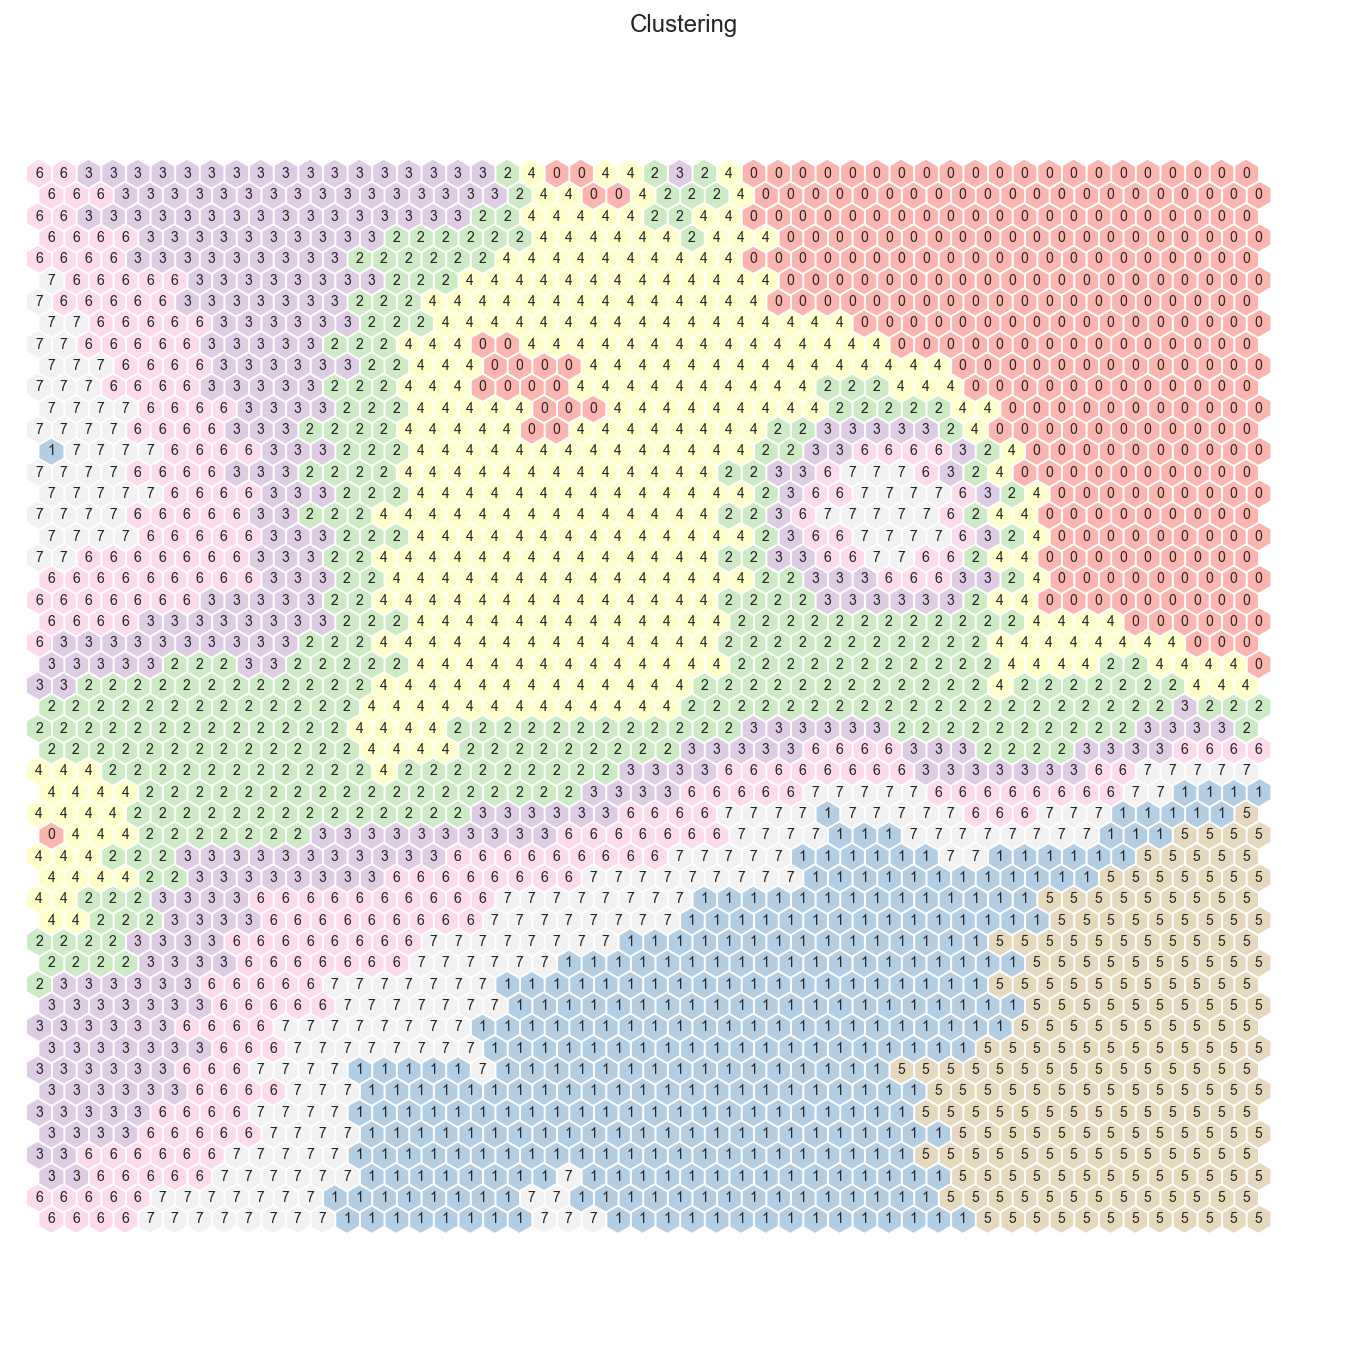

In [210]:
# Perform K-Means clustering on top of the 2500 untis (sm.get_node_vectors() output)
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=20, random_state=42)

hits  = HitMapView(12, 12,"Clustering", text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

#### Hierarchical Clustering on top of SOM units 

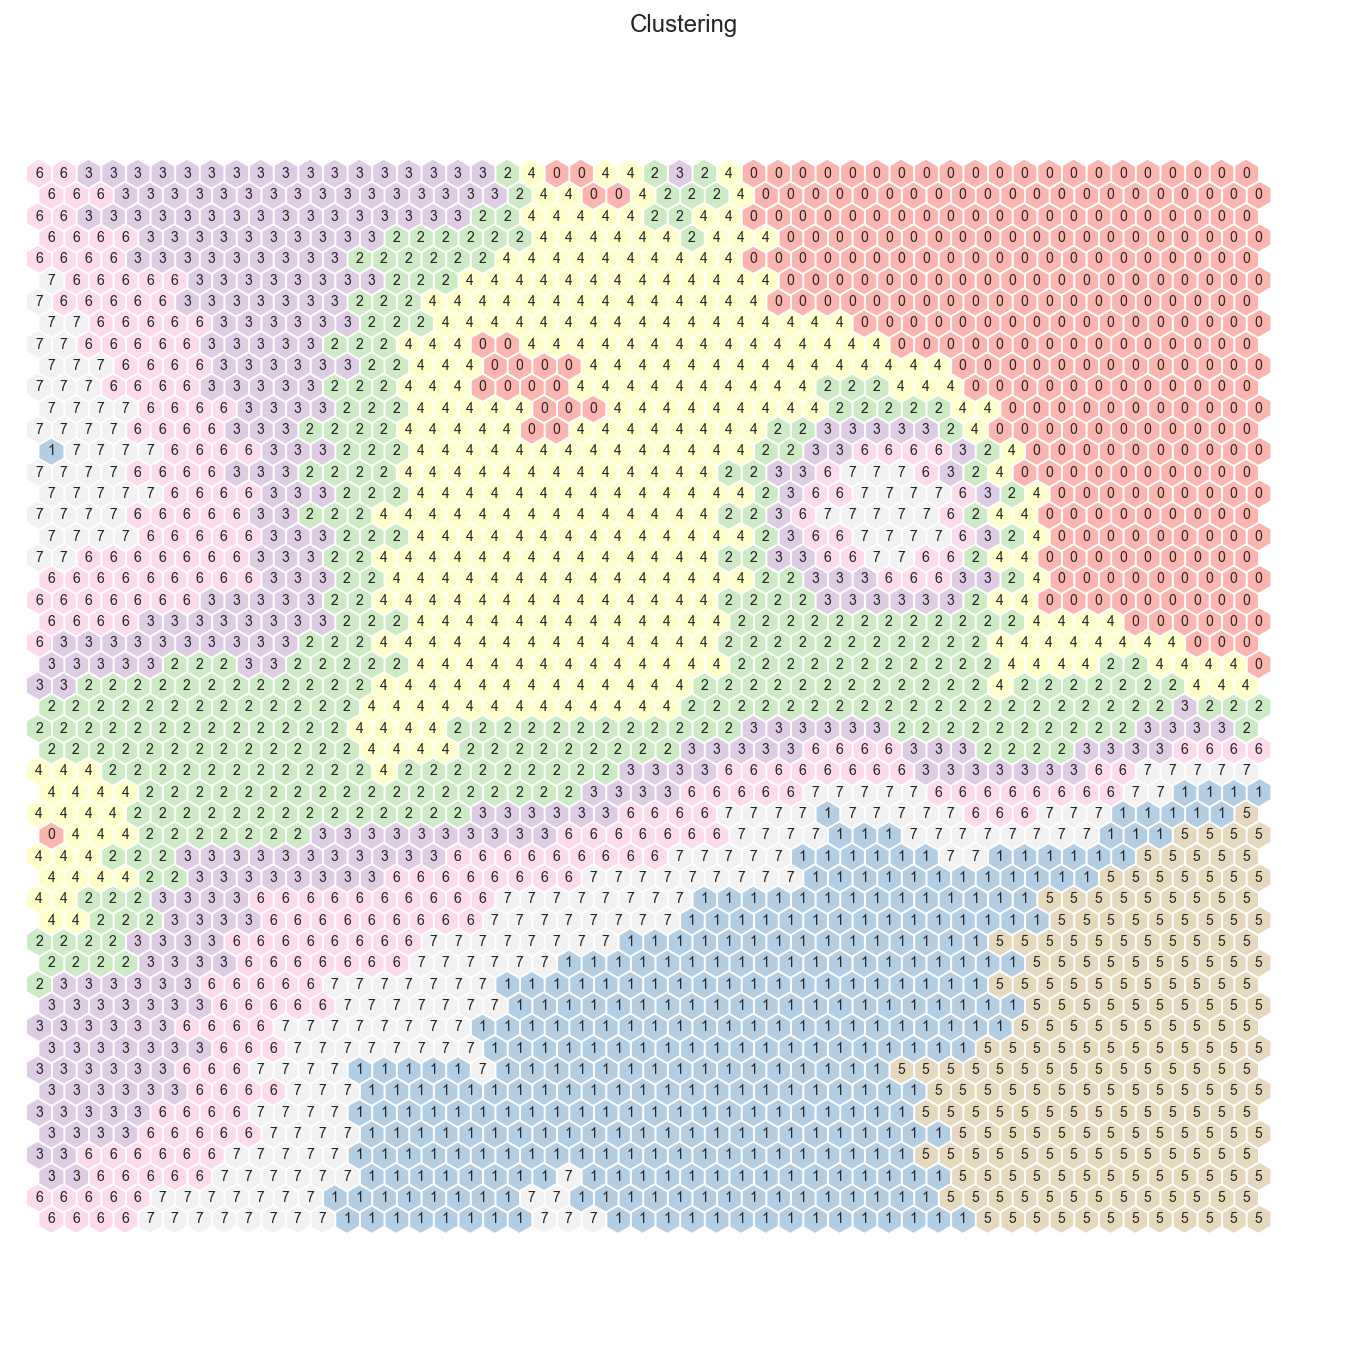

In [211]:
# Perform Hierarchical clustering on top of the 2500 untis (sm.get_node_vectors() output)
hierclust = AgglomerativeClustering(n_clusters=4, linkage='ward')

hits  = HitMapView(12, 12,"Clustering",text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

### Final SOM Clustering solution 

In [212]:
# Obtaining SOM's BMUs labels
bmus_map = sm.find_bmu(df_preprocessed[metric_features])[0]  # get bmus for each observation in df

df_final = pd.DataFrame(
    np.concatenate((df, np.expand_dims(bmus_map,1)), axis=1),
    index=df.index, columns=np.append(df.columns,"BMU")
)
df_final

Salary  Children       CMV    Claims     Motor  Household    Health  \
0     -0.358166  0.641444  0.514958 -0.608190  0.545143  -0.549810 -0.303422   
1     -1.905865  0.641444 -0.963764  0.858230 -1.666487   1.184846 -0.703117   
2     -0.254986 -1.558983  0.872150 -0.829157 -0.712652   0.197367 -0.596828   
3     -1.470446  0.641444 -0.634177  0.597087 -0.888091  -0.735768  1.916789   
4     -0.785331  0.641444 -0.483388  0.416295  0.269199  -0.712845  0.184644   
...         ...       ...       ...       ...       ...        ...       ...   
10290 -1.958487  0.641444 -0.076155  0.315856 -2.189543   3.566233 -0.885788   
10291  0.684983 -1.558983 -0.585435  0.536823  0.677742  -0.704346  0.066366   
10293  0.406397  0.641444  0.928255 -0.969773  0.751045  -0.274995 -0.358789   
10294 -0.570717  0.641444  0.136918 -0.085903 -0.842805   0.128599  0.397222   
10295  0.300122  0.641444  0.753991 -0.849245  0.828499  -0.472543 -0.372261   

           Life  Work Compensation   age  x0_1 - Basic  x0_2 - High School  \
0      0.140625          -0.502876  39.0           0.0                 1.0   
1      3.359594           1.466600  26.0           0.0                 1.0   
2      0.999337           1.309687  51.0           1.0                 0.0   
3     -0.114107          -0.250181  40.0           0.0                 0.0   
4     -0.475578           0.039149  48.0           0.0                 0.0   
...         ...                ...   ...           ...                 ...   
10290  1.581489           3.566066  22.0           1.0                 0.0   
10291 -0.672029          -0.549443  72.0           0.0                 0.0   
10293 -0.608947          -0.767709  45.0           0.0                 0.0   
10294  0.509299           1.616231  44.0           1.0                 0.0   
10295 -0.735112          -0.591154  40.0           0.0                 0.0   

       x0_3 - BSc/MSc  x0_4 - PhD     BMU  
0                 0.0         0.0  2450.0  
1                 0.0         0.0  2450.0  
2                 0.0         0.0  2450.0  
3                 1.0         0.0  2450.0  
4                 1.0         0.0  2450.0  
...               ...         ...     ...  
10290             0.0         0.0  2450.0  
10291             0.0         1.0  2450.0  
10293             1.0         0.0  2450.0  
10294             0.0         0.0  2450.0  
10295             0.0         1.0  2450.0  

[10034 rows x 15 columns]

### Analysing the appropriateness of our solution 

In [215]:
# using R^2
def get_ss(df_preprocessed):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

sst = get_ss(df_final[metric_features])  # get total sum of squares

ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

0.22849006434604144

# Density Based Clustering

In [ ]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

In [222]:
# The following bandwidth can be automatically detected using (we need to set quantile though)
# Based on distance to nearest neighbors for all observations
bandwidth = estimate_bandwidth(df_preprocessed[metric_features], quantile=0.06, random_state=1, n_jobs=-1)
bandwidth

3.8352159025989048

In [223]:
# Perform mean-shift clustering with bandwidth set using estimate_bandwidth
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=4)
ms_labels = ms.fit_predict(df_preprocessed[metric_features])

ms_n_clusters = len(np.unique(ms_labels))
print("Number of estimated clusters : %d" % ms_n_clusters)

Number of estimated clusters : 18


In [226]:
# Concatenating the labels to df
df_concat = pd.concat([df_preprocessed[metric_features], pd.Series(ms_labels, index=df.index, name="ms_labels")], axis=1)
df_concat.head()


Salary  Children       CMV    Claims     Motor  Household    Health  \
0 -0.358166  0.641444  0.514958 -0.608190  0.545143  -0.549810 -0.303422   
1 -1.905865  0.641444 -0.963764  0.858230 -1.666487   1.184846 -0.703117   
2 -0.254986 -1.558983  0.872150 -0.829157 -0.712652   0.197367 -0.596828   
3 -1.470446  0.641444 -0.634177  0.597087 -0.888091  -0.735768  1.916789   
4 -0.785331  0.641444 -0.483388  0.416295  0.269199  -0.712845  0.184644   

       Life  Work Compensation   age  ms_labels  
0  0.140625          -0.502876  39.0          4  
1  3.359594           1.466600  26.0          7  
2  0.999337           1.309687  51.0          5  
3 -0.114107          -0.250181  40.0          4  
4 -0.475578           0.039149  48.0          1

In [227]:
# Computing the R^2 of the cluster solution
sst = get_ss(df_preprocessed[metric_features])  # get total sum of squares
ssw_labels = df_concat.groupby(by='ms_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of -17.0000


### DBSCAN (Density-based spatial clustering of applications with noise) 

In [228]:
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=1.9, min_samples=20, n_jobs=4)
dbscan_labels = dbscan.fit_predict(df[metric_features])

dbscan_n_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters : %d" % dbscan_n_clusters)

Number of estimated clusters : 4


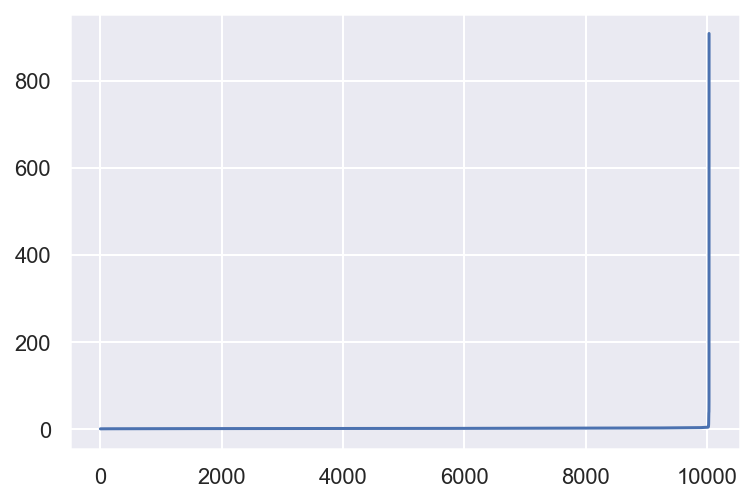

In [230]:
# K-distance graph to find out the right eps value
neigh = NearestNeighbors(n_neighbors=20)
neigh.fit(df_preprocessed[metric_features])
distances, _ = neigh.kneighbors(df_preprocessed[metric_features])
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.show()

In [231]:
# Concatenating the labels to df
df_concat = pd.concat([df_preprocessed[metric_features], pd.Series(dbscan_labels, index=df.index, name="dbscan_labels")], axis=1)
df_concat.head()

Salary  Children       CMV    Claims     Motor  Household    Health  \
0 -0.358166  0.641444  0.514958 -0.608190  0.545143  -0.549810 -0.303422   
1 -1.905865  0.641444 -0.963764  0.858230 -1.666487   1.184846 -0.703117   
2 -0.254986 -1.558983  0.872150 -0.829157 -0.712652   0.197367 -0.596828   
3 -1.470446  0.641444 -0.634177  0.597087 -0.888091  -0.735768  1.916789   
4 -0.785331  0.641444 -0.483388  0.416295  0.269199  -0.712845  0.184644   

       Life  Work Compensation   age  dbscan_labels  
0  0.140625          -0.502876  39.0              0  
1  3.359594           1.466600  26.0              0  
2  0.999337           1.309687  51.0             -1  
3 -0.114107          -0.250181  40.0              0  
4 -0.475578           0.039149  48.0              0

In [232]:
# Detecting noise (potential outliers)
df_concat.loc[df_concat['dbscan_labels'] == -1]

Salary  Children       CMV    Claims     Motor  Household    Health  \
2     -0.254986 -1.558983  0.872150 -0.829157 -0.712652   0.197367 -0.596828   
13    -1.528227  0.641444 -0.802031  0.737703 -1.911968   0.807008 -0.554932   
16    -0.089898  0.641444 -0.294686  0.396207 -1.352668   2.375540  0.000491   
29     0.140193 -1.558983 -0.579342  0.536823  1.644769  -0.830292 -1.535511   
35    -0.107439 -1.558983 -0.429766  0.396207 -0.450717   0.022742 -0.580393   
...         ...       ...       ...       ...       ...        ...       ...   
10269 -0.687310  0.641444 -1.185471  1.300165 -0.939159  -1.167951  1.175730   
10277 -1.492114 -1.558983  0.084624 -0.065815 -0.262084   0.131432  0.633779   
10287  1.362875 -1.558983 -0.297891  0.416295 -1.593183   3.385942 -0.637242   
10288 -1.092807  0.641444  1.710930 -0.688542 -1.738160   3.265662 -0.899259   
10290 -1.958487  0.641444 -0.076155  0.315856 -2.189543   3.566233 -0.885788   

           Life  Work Compensation   age  dbscan_labels  
2      0.999337           1.309687  51.0             -1  
13     4.963075           1.209050  21.0             -1  
16     1.855648          -0.053984  32.0             -1  
29    -0.732711          -0.985976  49.0             -1  
35     1.554858           0.576319  55.0             -1  
...         ...                ...   ...            ...  
10269  2.221921          -0.632865  45.0             -1  
10277 -0.026795          -0.228112  37.0             -1  
10287  2.561564          -0.137406  80.0             -1  
10288  3.097658           1.032495  28.0             -1  
10290  1.581489           3.566066  22.0             -1  

[1386 rows x 11 columns]

In [233]:
# Computing the R^2 of the cluster solution
df_nonoise = df_concat.loc[df_concat['dbscan_labels'] != -1]
sst = get_ss(df[metric_features])  # get total sum of squares
ssw_labels = df_nonoise.groupby(by='dbscan_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of -2.0000


### GMM (Gaussian Mixture Model ) 

In [235]:
# Performing GMM clustering
gmm = GaussianMixture(n_components=4, covariance_type='full', n_init=10, init_params='kmeans', random_state=1)
gmm_labels = gmm.fit_predict(df_preprocessed[metric_features])
labels_proba = gmm.predict_proba(df_preprocessed[metric_features])

In [236]:
# The estimated component weights
gmm.weights_

array([2.90712320e-01, 4.17632010e-02, 9.96611521e-05, 6.67424818e-01])

In [237]:
# The estimated mean vectors of the Components
gmm.means_

array([[ 7.34810002e-01, -1.55898279e+00,  8.40431988e-03,
         2.48532676e-02, -4.03441304e-01,  1.93906579e-01,
         4.27925758e-01,  1.89839118e-01,  1.41531310e-01,
         6.67655258e+01],
       [-1.12971662e+00,  6.04726101e-01, -2.44266472e-01,
         4.68590476e-01, -1.42021886e+00,  1.61296440e+00,
        -3.62924520e-01,  1.56828710e+00,  1.65418728e+00,
         3.24098665e+01],
       [ 3.15598779e-01, -1.55898279e+00, -1.63475133e-01,
         1.55152067e-01,  9.38862098e-01,  3.40747855e-02,
        -8.07923812e-01, -8.44251870e-01, -3.53245389e-01,
         9.93000000e+02],
       [-2.49420139e-01,  6.41443898e-01,  1.16483570e-02,
        -4.01699955e-02,  2.64456266e-01, -1.85394640e-01,
        -1.63562814e-01, -1.80696189e-01, -1.65103011e-01,
         4.88533595e+01]])

In [238]:
# The estimated covariance matrices of the Components
gmm.covariances_.shape


(4, 10, 10)

### Defining n_components: 

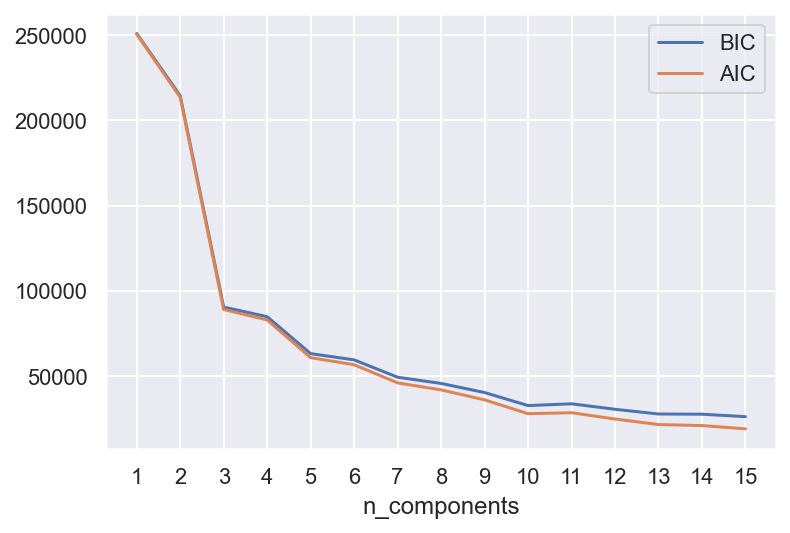

In [239]:
# Selecting number of components based on AIC and BIC
n_components = np.arange(1, 16)
models = [GaussianMixture(n, covariance_type='full', n_init=10, random_state=1).fit(df[metric_features])
          for n in n_components]

bic_values = [m.bic(df_preprocessed[metric_features]) for m in models]
aic_values = [m.aic(df_preprocessed[metric_features]) for m in models]
plt.plot(n_components, bic_values, label='BIC')
plt.plot(n_components, aic_values, label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.xticks(n_components)
plt.show()

In [240]:
# Performing GMM clustering
gmm = GaussianMixture(n_components=3, covariance_type='full', n_init=10, init_params='kmeans', random_state=1)
gmm_labels = gmm.fit_predict(df_preprocessed[metric_features])

In [241]:
# Concatenating the labels to df
df_concat = pd.concat([df_preprocessed[metric_features], pd.Series(gmm_labels, index=df.index, name="gmm_labels")], axis=1)
df_concat.head()

Salary  Children       CMV    Claims     Motor  Household    Health  \
0 -0.358166  0.641444  0.514958 -0.608190  0.545143  -0.549810 -0.303422   
1 -1.905865  0.641444 -0.963764  0.858230 -1.666487   1.184846 -0.703117   
2 -0.254986 -1.558983  0.872150 -0.829157 -0.712652   0.197367 -0.596828   
3 -1.470446  0.641444 -0.634177  0.597087 -0.888091  -0.735768  1.916789   
4 -0.785331  0.641444 -0.483388  0.416295  0.269199  -0.712845  0.184644   

       Life  Work Compensation   age  gmm_labels  
0  0.140625          -0.502876  39.0           2  
1  3.359594           1.466600  26.0           1  
2  0.999337           1.309687  51.0           0  
3 -0.114107          -0.250181  40.0           2  
4 -0.475578           0.039149  48.0           2

In [242]:
# Computing the R^2 of the cluster solution
sst = get_ss(df_preprocessed[metric_features])  # get total sum of squares
ssw_labels = df_concat.groupby(by='gmm_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of -2.0000
